# Vlasov Solver

We start by simulating the Vlasov system on the periodic domain $[-1,1]^2$ with a given Hamiltonian. We first implement a function which outputs the Hamiltonian vector field. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 8,8

x, v = sp.symbols("x,v", real = True)

# input $H$ as a sympy function
###############################
K = v**2/2
U = 0
Ham = K - U
###############################

# input number of grid points in each dimention
################################
Nx = 128
Nv = 256
################################

#initial condition for f
################################
def Fo(X,V):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    fo = np.exp(- 200*(V-1/3)**2 - 200*(X)**2)/0.015707963267949588
    
    # inposes periodicity
    fo[-1,:] = fo[0,:]
    fo[:,-1] = fo[:,0]
    return fo
################################

#define grid
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1, Nx+1) # the points x_{i}, X[0], X[-1] define the same point
V = np.linspace(-1,1,Nv+1) # the points v_{j}, V[0], V[-1] define the same point 
Xd = X + dx/2 # the points, x_{i+1/2}
Vd = V + dv/2 # the points, v_{i+1/2}

Xgrid, Vgrid = np.meshgrid(X,V)
Xgrid = Xgrid.transpose() 
Vgrid = Vgrid.transpose()

Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
Xdgrid = Xdgrid.transpose()
Vdgrid = Vdgrid.transpose()

# creates callable function for the derivatives of H
Kv = sp.diff(K,v)
Ux = sp.diff(U,x)
K = np.zeros_like(Xgrid)
U = np.zeros_like(Xgrid)
H = np.zeros_like(Xgrid)
for i in range(Nx+1):
    for j in range(Nv+1):
        K[i,j] = Kv.subs([(x,X[i]),(v,Vd[j])])
        U[i,j] = Ux.subs([(x,Xd[i]),(v,V[j])])
        H[i,j] = Ham.subs([(x,Xd[i]),(v,Vd[j])])


We now implement our first order solver. Our solver outputs $\int dx dv f(t)$ and the $L^{2}$ norm of $f$ as a function of time. The $L^{2}$ norm is a proxy for the numerical diffusion error in our simulation, since it is ideally conserved. 

In [2]:
def get_fluxes(F, K, U):
    """
    Gives the upwinded fluxes at each timestep
    
    inputs F,K, U 
    returns fluxes Fx, Fv as numpy arrays
    """
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:, :] = K[1:,:]*(F[1:,:] + F[0:-1,:])/2 - abs(K[1:,:])*(F[1:,:] -  F[0:-1,:])/2
    Fv[:, 1:] = U[:,1:]*(F[:,1:]+ F[:,0:-1])/2 - abs(U[:,1:])*(F[:,1:]- F[:,0:-1])/2
    Fx[0,:] = Fx[-1,:]
    Fv[:,0] = Fv[:,-1]
    return Fx, Fv

def frd_euler_step(F, Fx, Fv, dt, dx, dv):
    """
    outputs a forward euler step using first order upwinding
    """
    F[0:-1,0:-1] = F[0:-1,0:-1] - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    F[-1,0:-1] = F[0,0:-1]
    F[0:-1,-1] = F[0:-1,0]
    F[-1,-1] = F[0,0]
    return F

def first_order_integrate(F,K,U, dt, dx, dv, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using 1st order upwinding
    returns a numpy array of $t_{n}$, $L^1(t)$, $L^2(t)$, $f(t_{f})$
    """
    num_time_steps = math.ceil(tfin/dt)
    times = np.arange(num_time_steps)*dt
    L1_norms = [np.sum(F[0:-1,0:-1])*(dx*dv)]
    L2_norms = [np.linalg.norm(F[0:-1,0:-1])*math.sqrt(dx*dv)]
    for _ in range(num_time_steps -1):
        Fx, Fv = get_fluxes(F,K,U)
        F = frd_euler_step(F, Fx, Fv, dt, dx, dv)
        L1_norms.append(np.sum(F[0:-1,0:-1])*(dx*dv))
        L2_norms.append(np.linalg.norm(F)*math.sqrt(dx*dv))

    return times, L1_norms, L2_norms, F

Using the initial condition of a sharply peaked Gaussian centered at  $(x,v) = (0,1/3)$, we simulate the free Hamiltonian $H(v) = v^2/2$. The center of $f$ travels at a speed of $1/3$ so we plot in timesteps of $6$, the period time for the center of $f$. We should see that $f$ shears in the direction of increasing $v$. The courant condition is $dt < dx$, so we set $dt = dx$.

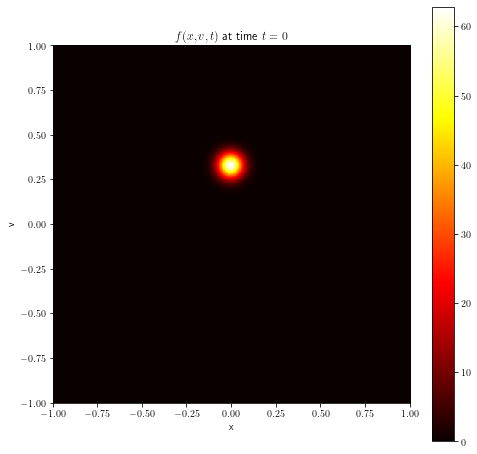

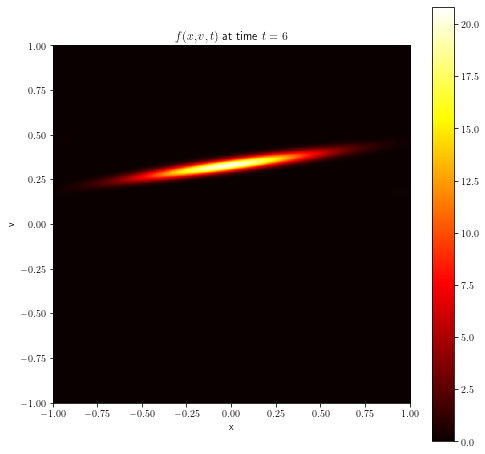

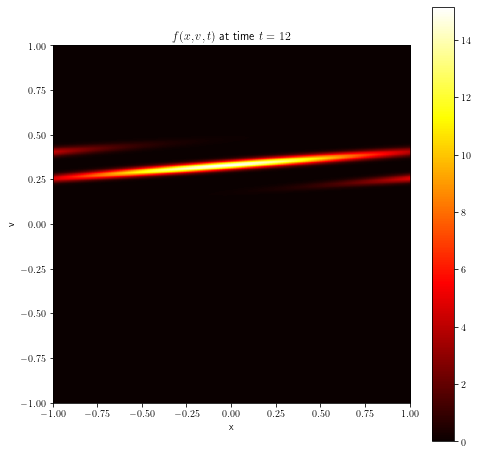

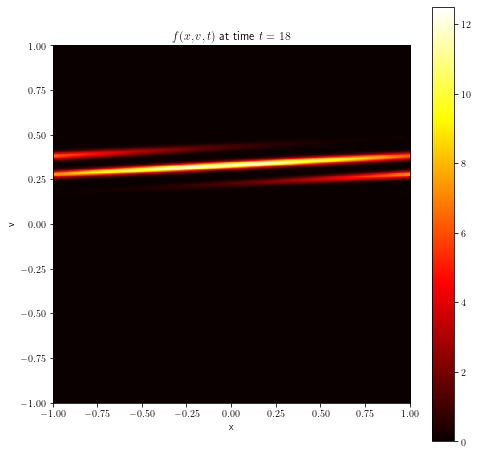

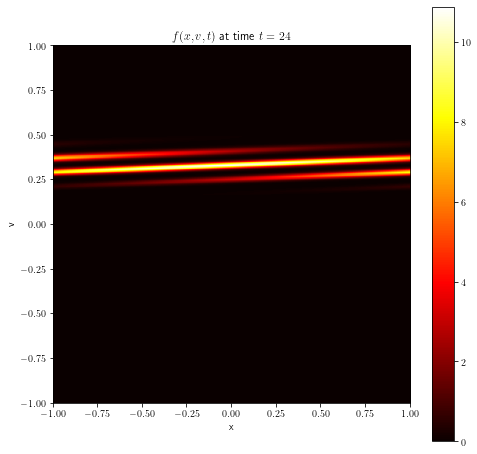

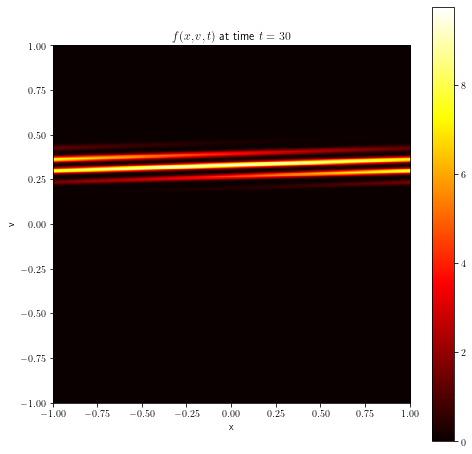

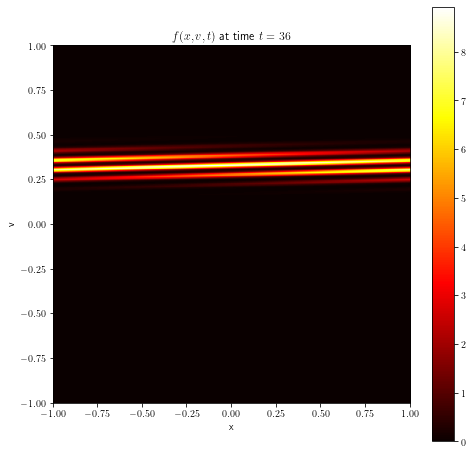

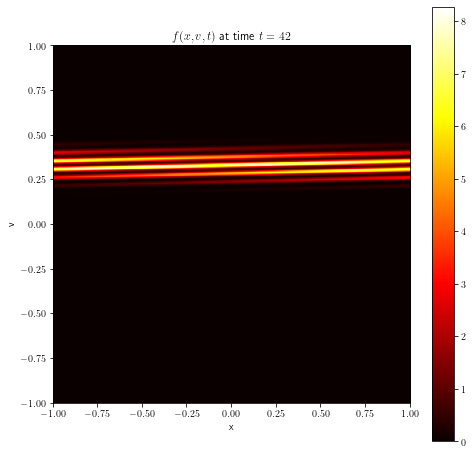

In [3]:
F = Fo(Xdgrid, Vdgrid)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()
for i in range(1,8):
    F = first_order_integrate(F,K,U,dx, dx, dv, 6)[3]
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {6*i}$")
    plt.show()

This looks like the expected result. We can run the simulation for long times and plot the $L^1$ and $L^2$ norms. 

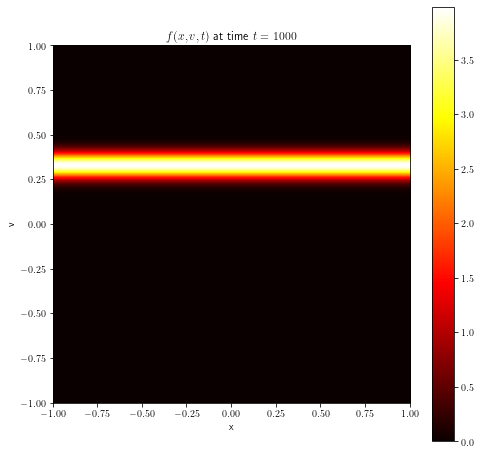

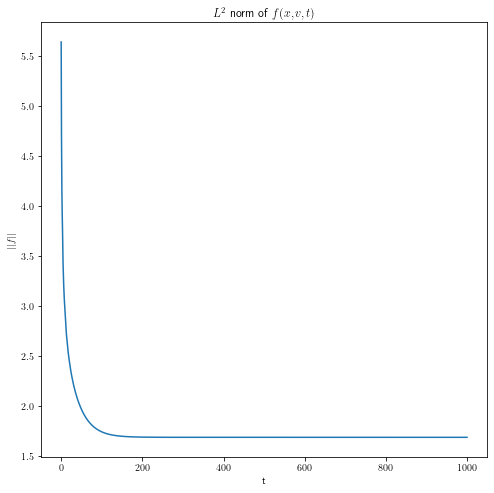

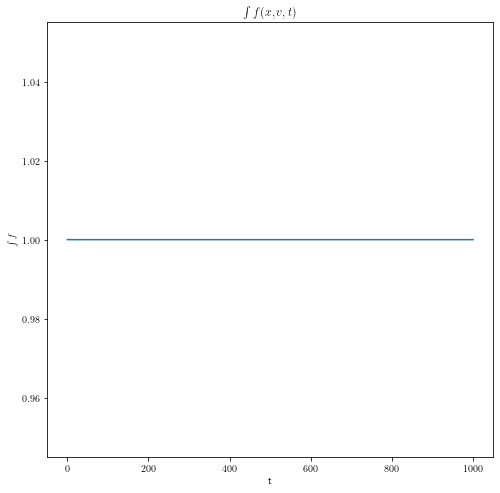

In [4]:
times, L1, L2, F= first_order_integrate(Fo(Xdgrid, Vdgrid),K,U,dx, dx, dv, 1000)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {1000}$")
plt.show()

plt.plot(times,L2)
plt.title("$L^2$ norm of $f(x,v,t)$")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.show()

plt.plot(times,L1) 
plt.title("$\int f(x,v,t)$")
plt.xlabel("t")
plt.ylabel("$\int f$")
plt.show()

Good! Our scheme works wonderfully. As predicted. Next we simulate the simple harmonic osciltor. The courant condition is $\Delta t< (1/\Delta x + 1/\Delta v)^{-1}$. Taking $\Delta x = \Delta v$ this gives $\Delta t < \Delta x/2$. The period time of the simple harmonic oscilator is $2\pi$, so we simulate in time intervals of $2\pi$. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math
plt.rcParams['text.usetex'] = True

x, v = sp.symbols("x,v", real = True)

# input $H$ as a sympy function
###############################
K = v**2/2
U = -x**2/2
Ham = K - U
###############################

# input number of grid points in each dimention
################################
Nx = 200
Nv = 200
################################

#initial condition for f
################################
def Fo(X,V):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    fo = np.exp(- 200*(V-1/3)**2 - 200*X**2)/0.015707963267949588
    
    # inposes periodicity
    fo[-1,:] = fo[0,:]
    fo[:,-1] = fo[:,0]
    return fo
################################

#define grid
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1, Nx+1) # the points x_{i}, X[0], X[-1] define the same point
V = np.linspace(-1,1,Nv+1) # the points v_{j}, V[0], V[-1] define the same point 
Xd = X + dx/2 # the points, x_{i+1/2}
Vd = V + dv/2 # the points, v_{i+1/2}

Xgrid, Vgrid = np.meshgrid(X,V)
Xgrid = Xgrid.transpose() 
Vgrid = Vgrid.transpose()

Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
Xdgrid = Xdgrid.transpose()
Vdgrid = Vdgrid.transpose()

# creates callable function for the derivatives of H
Kv = sp.diff(K,v)
Ux = sp.diff(U,x)
K = np.zeros_like(Xgrid)
U = np.zeros_like(Xgrid)
H = np.zeros_like(Xgrid)
for i in range(Nx+1):
    for j in range(Nv+1):
        K[i,j] = Kv.subs([(x,X[i]),(v,Vd[j])])
        U[i,j] = Ux.subs([(x,Xd[i]),(v,V[j])])
        H[i,j] = Ham.subs([(x,Xd[i]),(v,Vd[j])]) 

We see that the first order method is very diffusive! But it works. We now turn to the true Vlasov equation. We define a function that obtain and interpolate the electric field at each timestep. 

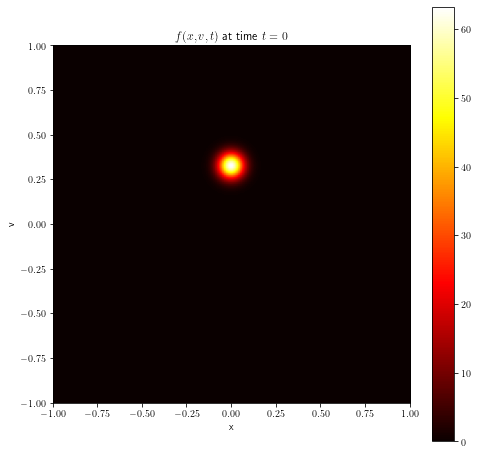

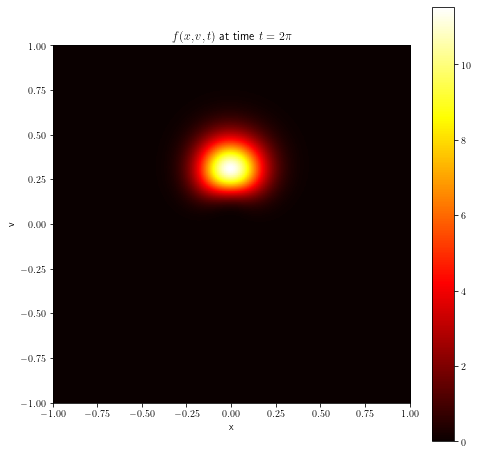

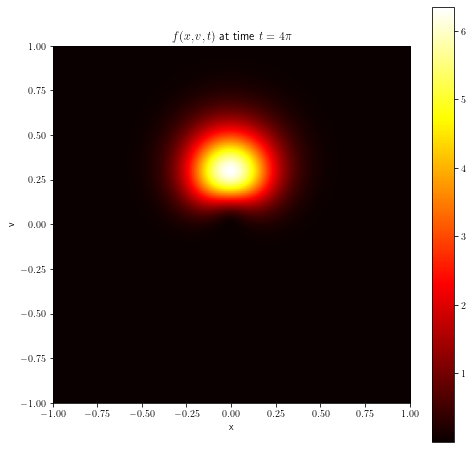

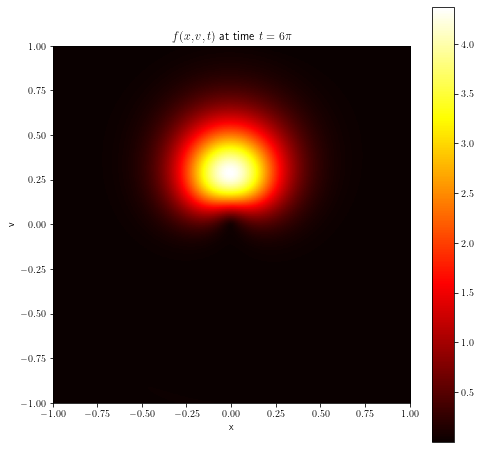

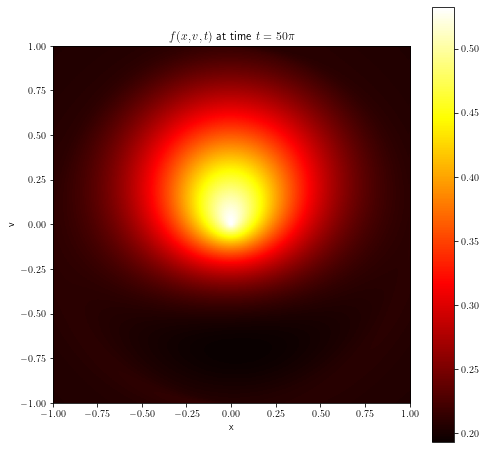

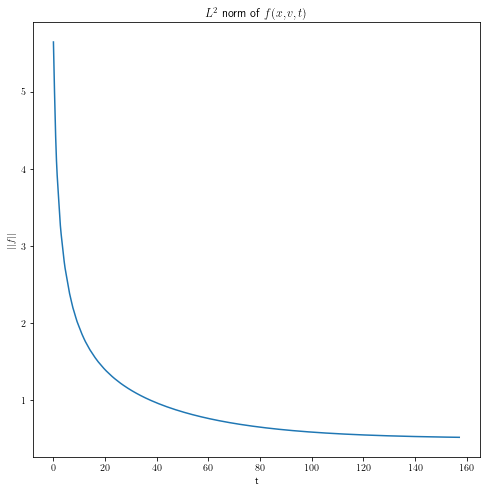

In [6]:
F = Fo(Xdgrid, Vdgrid)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()
for i in range(1,4):
    F = first_order_integrate(F,K,U,dx/2, dx, dv, 2*np.pi)[3]
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {2*i}\pi$")
    plt.show()
    
times, L1, L2, F= first_order_integrate(Fo(Xdgrid, Vdgrid),K,U,dx/2, dx, dv, 50*np.pi)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {50}\pi$")
plt.show()

plt.plot(times,L2)
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.title("$L^2$ norm of $f(x,v,t)$")
plt.show()

We see that our solver works, but it is very diffusive. This makes sense, since we are using a first-order, upwinded method. 

We now solve the true Vlasov equation. We define a function that gets and interpolates the electric field at each timestep. The time integration and spacial discretization are still based on the first order method but the timestep $\Delta t$ is solved for at each step. The electric field is solved for at each timestep.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import math

def get_E(F,dx,dv):
    """
    gets the electric field 
    returns E(x_{i}) as numpy array
    """
    n = dv*np.sum(F[:,0:-1],axis = 1)
    C = dx*np.sum(n[0:-1])/2
    E = np.zeros_like(n)
    l = len(n)-1
    for i in range(l-1):
        E[i+1] = E[i] + dx*(C-n[i])
    mean = np.sum(E[0:-1])/l
    return E - mean

def E_interp_1(E, Nx, Nv):
    """
    interpolates E(x_{i}) to E(x_{i+1/2}) and returns an array
    uses a simple 2-point average
    using kernel $x_{i},x_{i+1}$
    """
    Einterp = np.zeros_like(E)
    Einterp[0:-1] = (E[0:-1] + E[1:])/2
    Einterp[-1] = Einterp[0]
    V = np.empty(Nv+1)
    Egrid = np.meshgrid(E,V)[0]
    return Egrid.transpose()

def get_Vlasov_fluxes_1(F,E, K, Nx, Nv):
    """
    inputs F,K, dx, dv, Ein (an perscribed electric field)
    returns fluxes Fx, Fv 
    """ 
    dx = 2/Nx
    dv = 2/Nv
    U = -E_interp_1(E,Nx, Nv)
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    Fx[1:, :] = K[1:,:]*(F[1:,:] + F[0:-1,:])/2 - abs(K[1:,:])*(F[1:,:] -  F[0:-1,:])/2
    Fv[:, 1:] = U[:,1:]*(F[:,1:]+ F[:,0:-1])/2 - abs(U[:,1:])*(F[:,1:]- F[:,0:-1])/2
    Fx[0,:] = Fx[-1,:]
    Fv[:,0] = Fv[:,-1]
    return Fx, Fv

def frd_euler_1(F, Fx, Fv, dt, dx, dv):
    """
    outputs f^{n+1}, a forward euler step for the Vlasov R
    """
    F[0:-1,0:-1] = F[0:-1,0:-1] - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    F[-1,0:-1] = F[0,0:-1]
    F[0:-1,-1] = F[0:-1,0]
    F[-1,-1] = F[0,0]
    return F

def get_K(Nx, Nv):
    """
    return K array
    """
    #define grid
    X = np.linspace(-1,1, Nx+1)
    Vd = np.linspace(-1,1,Nv+1)+1/(Nv) 
    K = np.meshgrid(X,Vd)[1].transpose()
    #K[-1,:] = K[0,:]
    #K[:,-1] = K[:,0]
    return K

def Euler_Integrate_Vlasov_1(F, Nx, Nv, tfin,  c= 1):
    """
    integrates the vlasov equation using 1st order upwinding
    timestep $dt$ is chosen to be $c$ times the largest satifsying the Courant Condition
    returns a numpy array of $t_{n}$, $L^1(t)$, $L^2(t)$, $f(t_{f})$, and E(t_{f})
    """
    dx = 2/Nx
    dv = 2/Nv
    K = get_K(Nx,Nv)
    time = 0
    times = [0]
    L1_norms = [np.sum(F[0:-1,0:-1])*(dx*dv)]
    L2_norms = [np.linalg.norm(F[0:-1,0:-1])*math.sqrt(dx*dv)]
    while time < tfin:
        E = get_E(F,dx, dv)
        plt.show()
        a = np.max(abs(E))
        dt = c/(1/dx + a/dv)
        Fx, Fv = get_Vlasov_fluxes_1(F,E,K,Nx,Nv)
        F = frd_euler_1(F, Fx, Fv, dt, dx, dv)
        L1_norms.append(np.sum(F[0:-1,0:-1])*(dx*dv))
        L2_norms.append(np.linalg.norm(F)*math.sqrt(dx*dv))
        time = time + dt
        times.append(time)
    return times, L1_norms, L2_norms, F, E


As our first test, we simulate the two stream instabiliy. We use the initial condition $f(x,v,0) = f_{0} + f_{1}$ where $f_{0}$ is a Gaussian approximation of $\delta(v-v_{0}) + \delta(v+v_{0})$ and $f_{1} = \frac{f_{0}}{10} \sin(kx)$. For $k$ small we have an instability, so we first use $k = 2\pi$. We should see that the plasma oscilates before going nonlinearly unstable. 

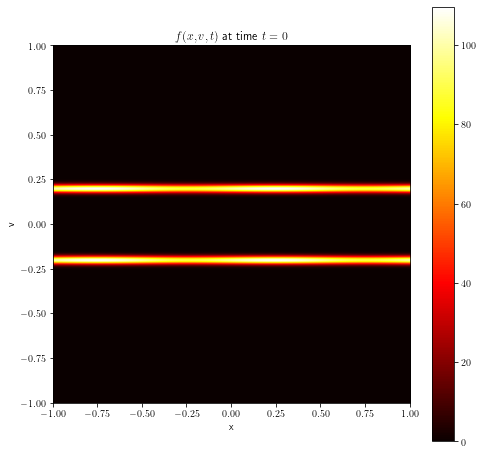

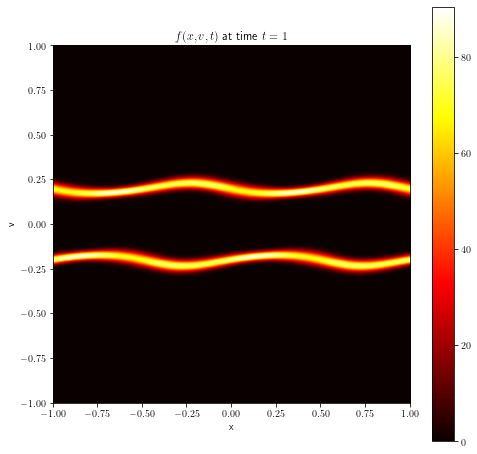

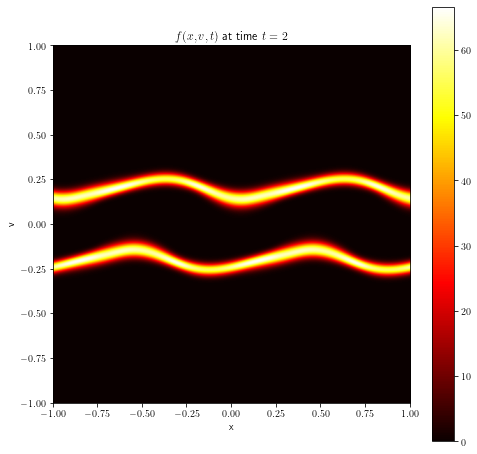

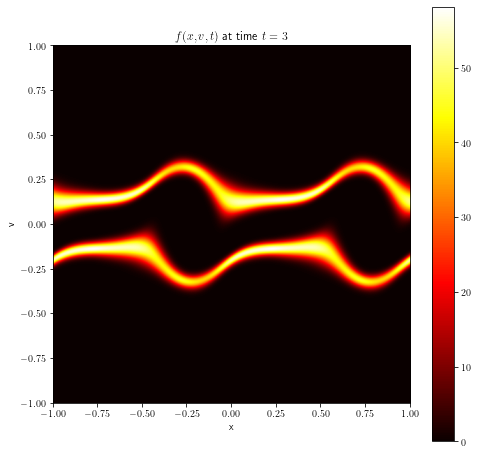

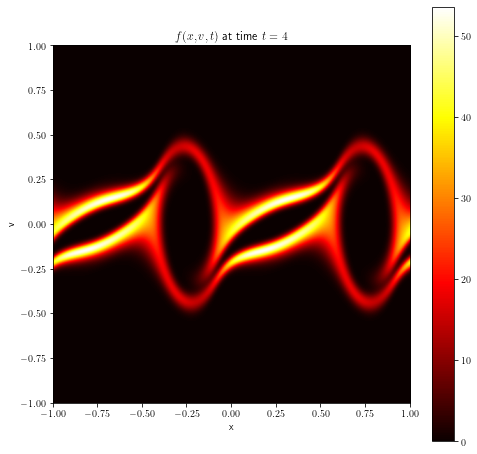

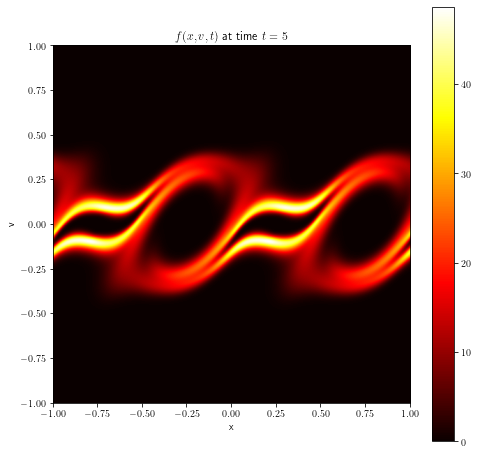

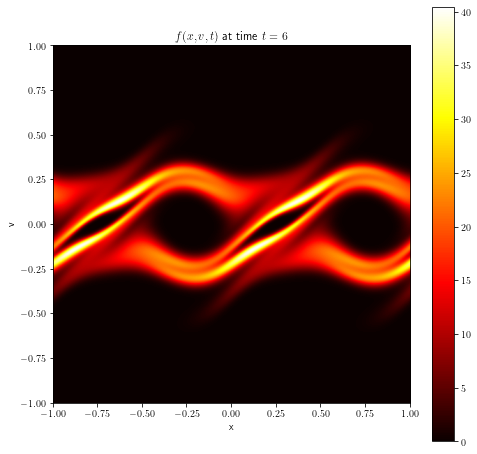

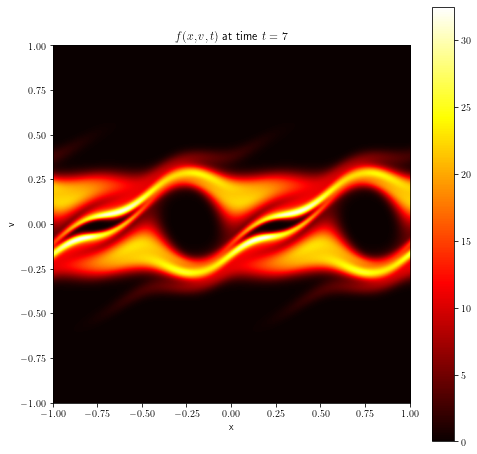

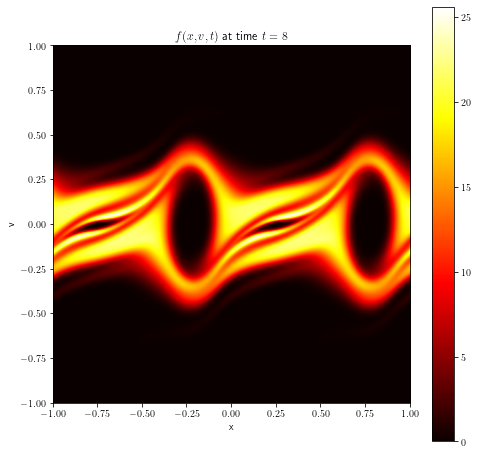

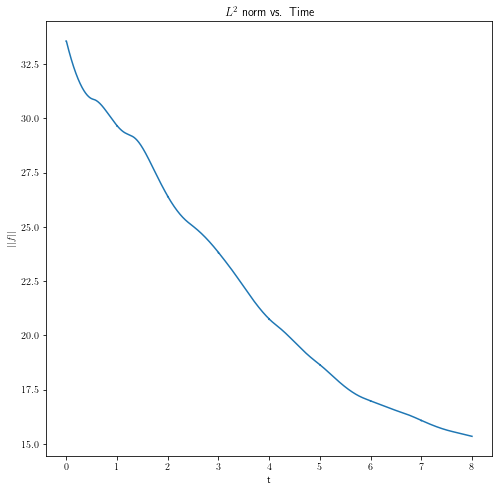

In [31]:
def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(Nx)
    V = np.linspace(-1,1,Nv+1)+1/(Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = 10*(10+np.sin(2*np.pi*X)) *(np.exp(- 2000*(V-.2)**2)+np.exp(- 2000*(V+.2)**2))
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo

Nx = 512
Ny = 512
Times = [0,1,2,3,4,5,6,7,8]
x = np.linspace(-1,1,Nx+1) + 1/Nx
F = Fo(Nx,Ny)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

times = []
L2tot = []
for i in range(1,len(Times)):
    time, L1, L2, F, E = Euler_Integrate_Vlasov_1(F,Nx, Ny, Times[i]-Times[i-1])
    times += [k + Times[i-1] for k in time]
    L2tot += L2
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {Times[i]}$")
    plt.show()

plt.plot(times, L2tot)
plt.xlabel("t")
plt.title("$L^2$ norm vs. Time")
plt.ylabel("$||f||$")
plt.show()

Wonderful! We now try to same test with $k = 8 \pi$. We should see that the perturbation oscilates without growing. Due to dissipation in the numerical scheme, the perturbation should in fact damp out. Indeed, we see this is the case. 

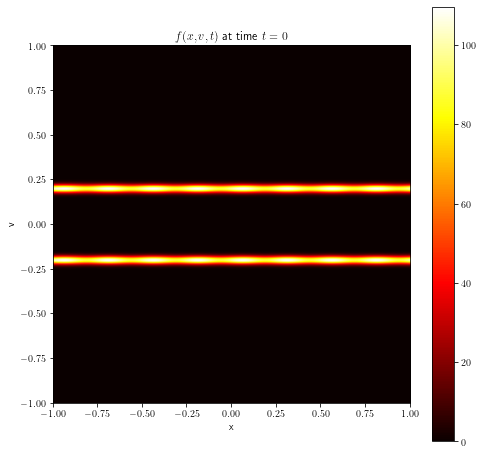

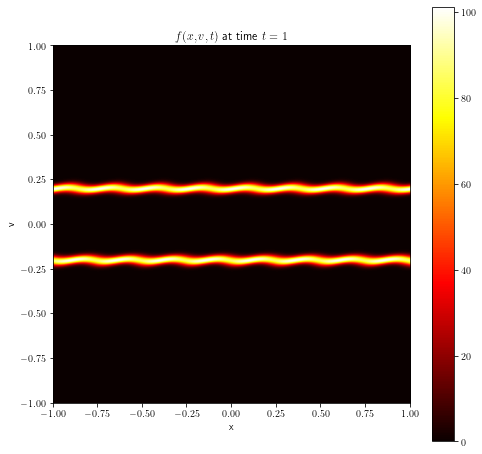

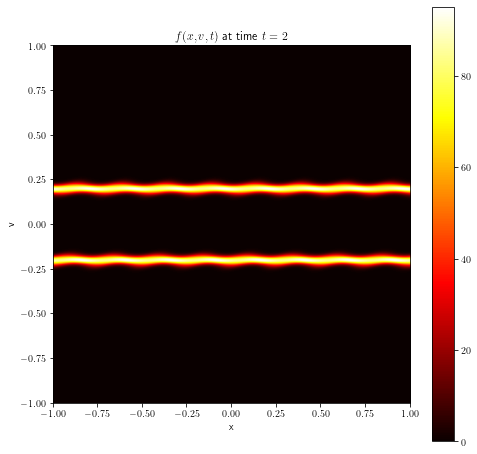

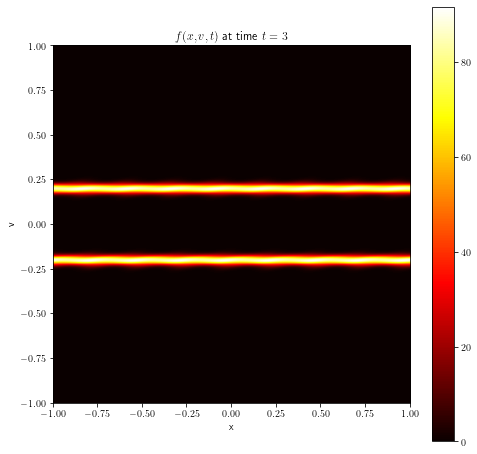

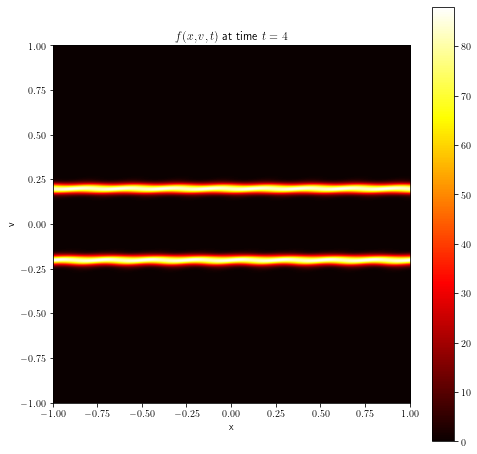

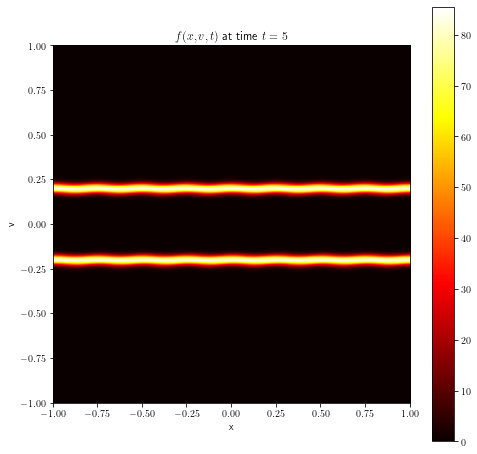

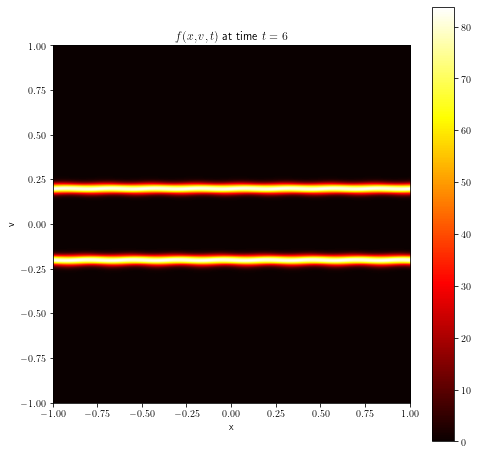

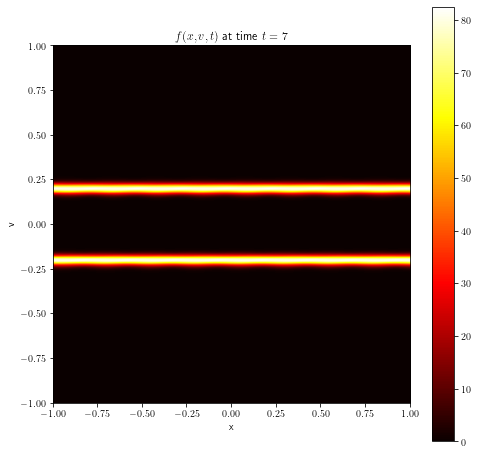

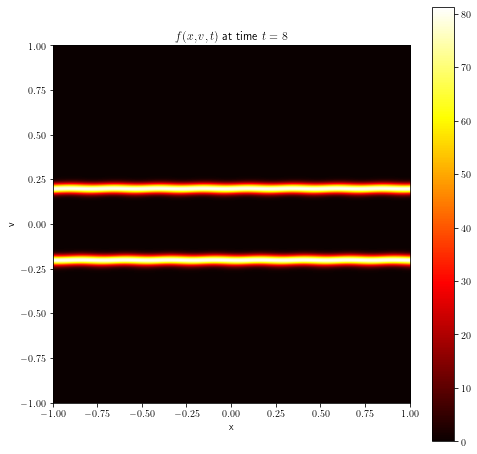

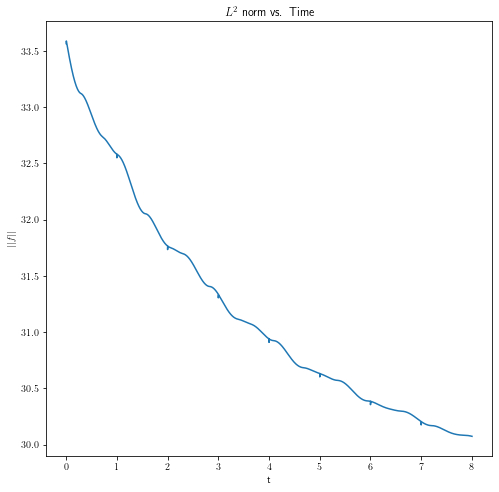

In [9]:
def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(Nx)
    V = np.linspace(-1,1,Nv+1)+1/(Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = 10*(10+np.sin(8*np.pi*X)) *(np.exp(- 2000*(V-.2)**2)+np.exp(- 2000*(V+.2)**2))
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo

Nx = 512
Ny = 512
Times = [0,1,2,3,4,5,6,7,8]
x = np.linspace(-1,1,Nx+1) + 1/Nx
F = Fo(Nx,Ny)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

times = []
L2tot = []
for i in range(1,len(Times)):
    time, L1, L2, F, E = Euler_Integrate_Vlasov_1(F,Nx, Ny, Times[i]-Times[i-1])
    times += [k + Times[i-1] for k in time]
    L2tot += L2
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {Times[i]}$")
    plt.show()

plt.plot(times, L2tot)
plt.title("$L^{2}$ norm vs. Time")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.show()

Next we implement a different electric field interpolator using Fourier interpolation. We plot the interpolated electric field from a point charge at $x = 0$ using 2-point and Fourier averaging at both low and high resolutions. At low resolution, we see Gibbs phenomena. At high resolutions, the interpolations are almost identical.

In [10]:

from scipy.fft import fft, ifft, fftfreq

def E_interp_2(E, Nx, Nv):
    """
    interpolates E(x_{i}) to E(x_{i+1/2}) and returns an array
    using kernel $x_{i},x_{i+1}
    """
    i = complex(0,1)
    Eint = np.empty(Nx+1)
    exp_freq = np.exp(i*np.pi*fftfreq(Nx))
    Ek = fft(E[0:-1])
    Eint[0:-1] = np.real(ifft(fft(E[0:-1])*exp_freq))
    Eint[-1]=Eint[0]
    V = np.empty(Nv+1)
    return np.meshgrid(Eint,V)[0].transpose()

def get_Vlasov_fluxes_2(F,E, K, Nx, Nv):
    """
    inputs F,K, dx, dv, Ein (an perscribed electric field)
    returns fluxes Fx, Fv 
    """ 
    dx = 2/Nx
    dv = 2/Nv
    U = -E_interp_2(E, Nx, Nv)
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    Fx[1:, :] = K[1:,:]*(F[1:,:] + F[0:-1,:])/2 - abs(K[1:,:])*(F[1:,:] -  F[0:-1,:])/2
    Fv[:, 1:] = U[:,1:]*(F[:,1:]+ F[:,0:-1])/2 - abs(U[:,1:])*(F[:,1:]- F[:,0:-1])/2
    Fx[0,:] = Fx[-1,:]
    Fv[:,0] = Fv[:,-1]
    return Fx, Fv

def frd_euler_2(F, Fx, Fv, dt, dx, dv):
    """
    outputs f^{n+1}, a forward euler step for the Vlasov R
    """
    F[0:-1,0:-1] = F[0:-1,0:-1] - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    F[-1,0:-1] = F[0,0:-1]
    F[0:-1,-1] = F[0:-1,0]
    F[-1,-1] = F[0,0]
    return F

def get_K(Nx, Nv):
    """
    return K array
    """
    #define grid
    X = np.linspace(-1,1, Nx+1)
    Vd = np.linspace(-1,1,Nv+1)+1/(Nv) 
    K = np.meshgrid(X,Vd)[1].transpose()
    #K[-1,:] = K[0,:]
    #K[:,-1] = K[:,0]
    return K

def Euler_Integrate_Vlasov_2(F, Nx, Nv, tfin,  c= 1):
    """
    integrates the vlasov equation using 1st order upwinding
    timestep $dt$ is chosen to be $c$ times the largest satifsying the Courant Condition
    returns a numpy array of $t_{n}$, $L^1(t)$, $L^2(t)$, $f(t_{f})$, and E(t_{f})
    """
    dx = 2/Nx
    dv = 2/Nv
    K = get_K(Nx,Nv)
    time = 0
    times = [0]
    L1_norms = [np.sum(F[0:-1,0:-1])*(dx*dv)]
    L2_norms = [np.linalg.norm(F[0:-1,0:-1])*math.sqrt(dx*dv)]
    while time < tfin:
        E = get_E(F,dx, dv)
        plt.show()
        a = np.max(abs(E))
        dt = c/(1/dx + a/dv)
        Fx, Fv = get_Vlasov_fluxes_2(F,E,K,Nx,Nv)
        F = frd_euler_2(F, Fx, Fv, dt, dx, dv)
        L1_norms.append(np.sum(F[0:-1,0:-1])*(dx*dv))
        L2_norms.append(np.linalg.norm(F)*math.sqrt(dx*dv))
        time = time + dt
        times.append(time)
    return times, L1_norms, L2_norms, F, E

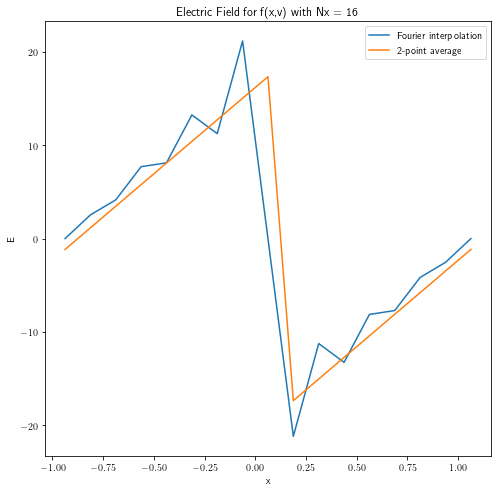

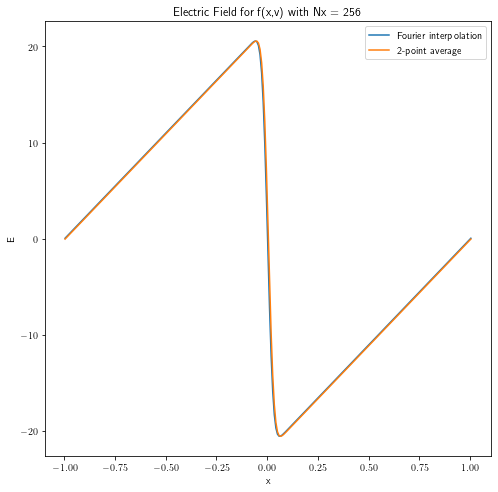

In [11]:
def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(2*Nx)
    V = np.linspace(-1,1,Nv+1)+1/(2*Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = 100*np.exp(- 200*(V)**2 - 1000*X**2)/0.015707963267949588
    Fo += np.ones_like(X)
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo

Nx = 2**4
Nv = 10
F = Fo(Nx,Nv)
E = get_E(F, 2/Nx, 2/Nv)
Einterp2 = E_interp_2(E, Nx, Nv)
Einterp1 = E_interp_1(E,Nx,Nv)
x = np.linspace(-1,1,Nx+1) + 1/Nx
plt.plot(x,Einterp2[:,0], label = "Fourier interpolation")
plt.plot(x,Einterp1[:,0], label = "2-point average")
plt.xlabel("x")
plt.ylabel("E")
plt.title("Electric Field for f(x,v) with Nx = 16")
plt.legend()
plt.show()

Nx = 256
Nv = 10
F = Fo(Nx,Nv)
E = get_E(F, 2/Nx, 2/Nv)
Einterp2 = E_interp_2(E, Nx, Nv)
Einterp1 = E_interp_1(E,Nx,Nv)
x = np.linspace(-1,1,Nx+1) + 1/Nx
plt.plot(x,Einterp2[:,0], label = "Fourier interpolation")
plt.plot(x,Einterp1[:,0], label = "2-point average")
plt.xlabel("x")
plt.ylabel("E")
plt.title("Electric Field for f(x,v) with Nx = 256")
plt.legend()
plt.show()

We now simulate plasma oscilations. We define a function that gets the negative charge density $c(x) = \int dv f - C$. We compare the use of the Fourier interpolated and second-order interpolated $E$. We will see the Fourier interpolation outperforms averaging. Indeed, $c(x)$ remains much more symmetric with Fourier interpolation. Still, the methods are comparable in accuracy. We note that numerical error causes the charge profile $c(x)$ to change shape. 

We use an initial condition of the form $f = f_{0}(v) + f_{1}(x,v,t)$ where $f_{1}$ is very small compared to $f_{0}$. $f_{0}$ is supported near $v = 0$ so we have a cold equilibrium. We normalize $f_{0}$ such that the plasma frequency is $\omega_{p} = 1$. We simulate in timesteps of $\pi$, so that $c(x)$ changes sign between the plots. We should see that $c(x)$ oscilates at the frequency $\omega_{p}/2\pi$. Indeed, we see oscilations. 

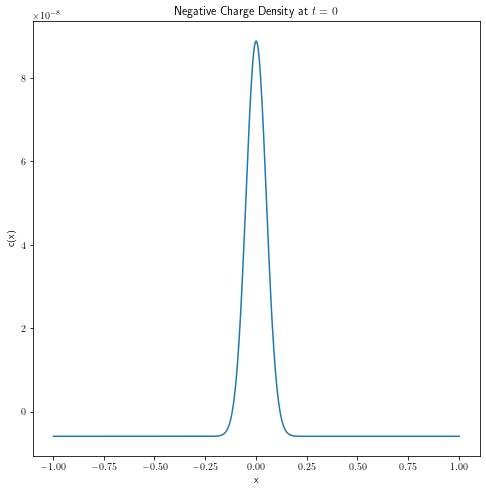

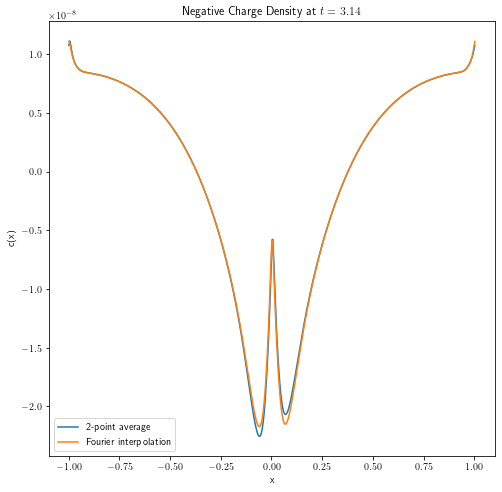

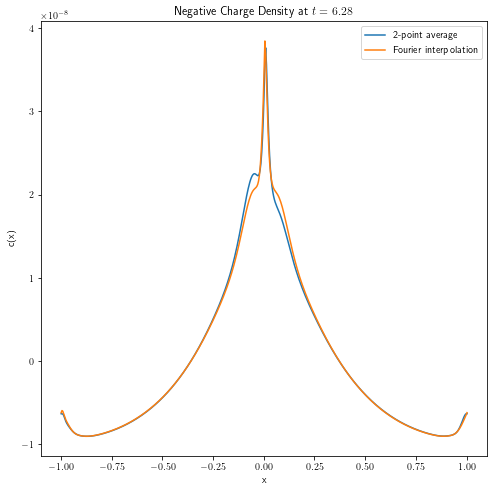

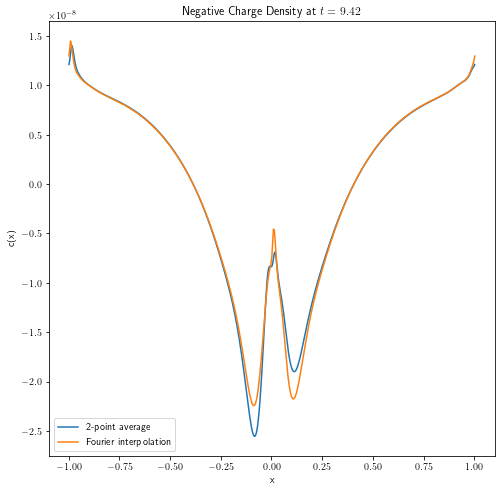

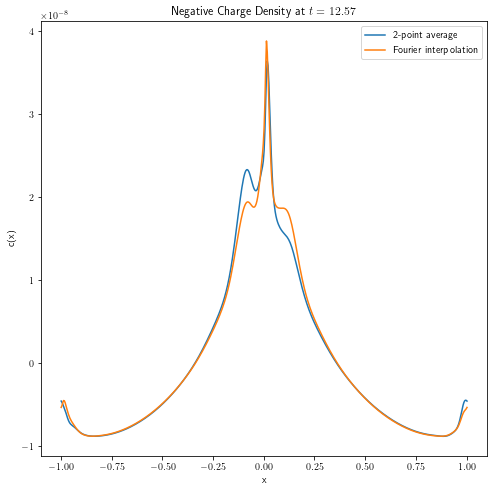

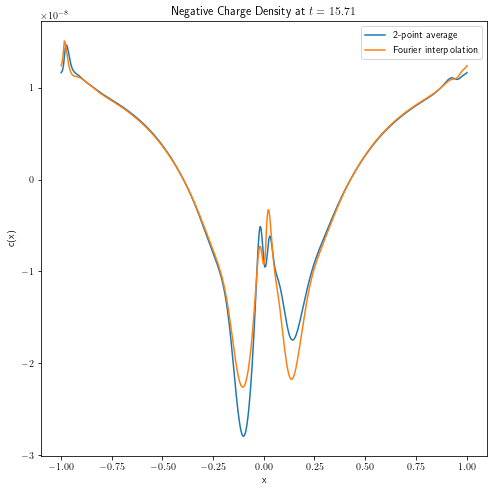

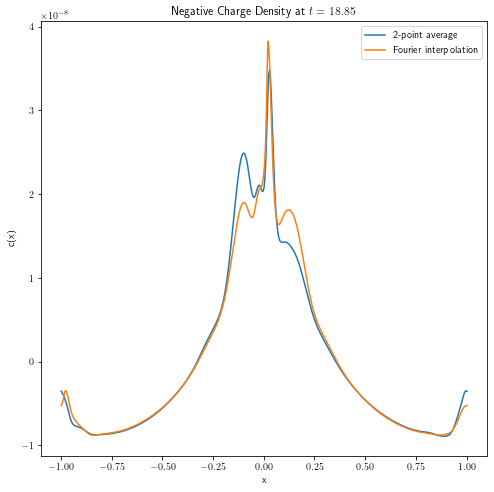

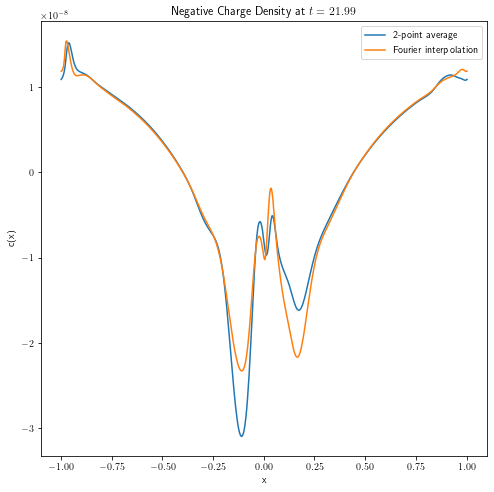

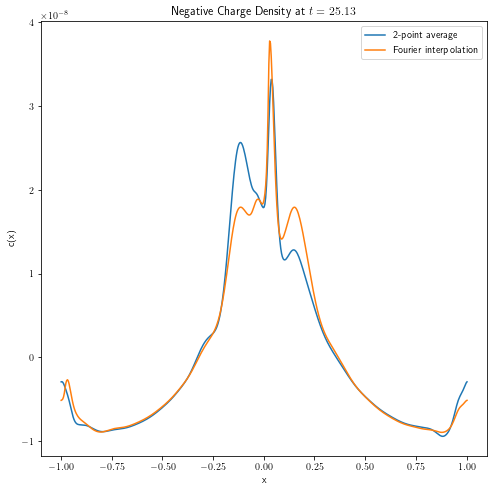

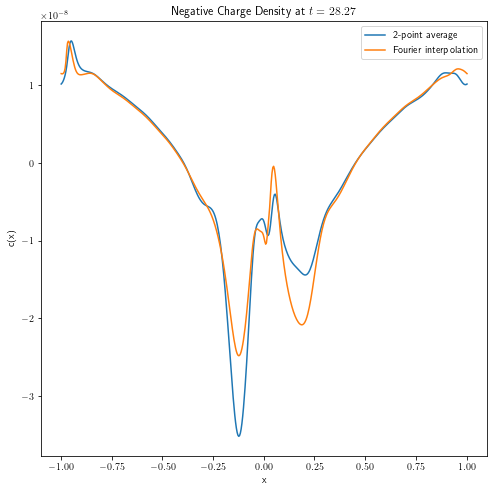

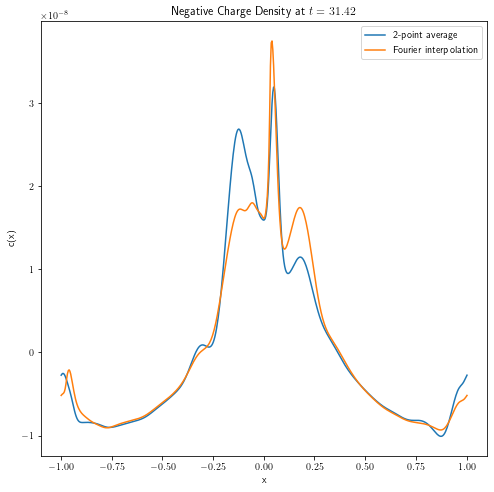

In [12]:
def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(2*Nx)
    V = np.linspace(-1,1,Nv+1)+1/(2*Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = np.exp(- 10000*V**2)/(1/100 * math.sqrt(np.pi)) # f_{0}
    Fo = Fo + 10**(-8) *.3* np.exp(- 10*V**2)/(1/100 * math.sqrt(np.pi))*\
    (np.exp(-200*X**2))
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo

def get_charge(F, dx, dv):
    """
    returns C(x_{i}) as numpy array
    """
    n = dv*np.sum(F[:,0:-1],axis = 1)
    C = dx*np.sum(n[0:-1])/2
    return n - C

Nx = 512
Nv = 512
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1,Nx+1) +1/Nx
Ffourier = Fo(Nx,Nv)
Fsimple = Fo(Nx,Nv)
Times = [i* np.pi for i in range(11)]
x = np.linspace(-1,1,Nx+1) + 1/Nx
c = get_charge(Fsimple,dx,dv)
plt.plot(X,c)
plt.title("Negative Charge Density at $t = 0$")
plt.xlabel("x")
plt.ylabel("c(x)")

for i in range(1,len(Times)):
    Ffourier= Euler_Integrate_Vlasov_2(Ffourier,Nx, Nv, Times[i]-Times[i-1])[3]
    Fsimple = Euler_Integrate_Vlasov_1(Fsimple,Nx,Nv, Times[i] - Times[i-1])[3]
    cfourier = get_charge(Ffourier,dx,dv)
    csimple = get_charge(Fsimple,dx,dv)
    plt.plot(X,csimple, label = "2-point average")
    plt.plot(X,cfourier, label = "Fourier interpolation")
    plt.title(f"Negative Charge Density at $t = {Times[i]:.2f}$")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("c(x)")
    plt.show()

Next we move onto the second order solver. We use a Fromm-like scheme to get the edge values of $f$. The numerical fluxes are determined by upwinding. The time integration is preformed using RK(2). We assume first a given Hamiltonian. 

In [33]:
import numpy as np
# F, K, U assumed to be $Nx+3 x Nv + 3$ arrays
# the periodicity condition is v[0] = v[-3], v[1] = v[-2], v[2] = v[-1]

def get_second_order_fluxes(F, K, U):
    """
    inputs F,K, U 
    returns fluxes Fx, Fv are numpy arrays of size Nx+, Nv+3
    """

    KF = np.zeros_like(F) # Gives $FK(x_{i},v_{j+1/2})$
    UF = np.zeros_like(F) # Gives $UK(x_{i},v_{j+1/2})$
    
    KF[2:-1,:] = K[2:-1,:]*(5*F[1:-2,:] + 5*F[2:-1,:] - F[0:-3,:] - F[3:,:])/8 \
    + abs(K[2:-1,:])*(3*F[1:-2,:] - 3*F[2:-1,:] - F[0:-3,:] + F[3:,:])/8
    
    #periodicity 
    KF[0,:] = KF[-3,:]
    KF[1,:] = KF[-2,:]
    KF[-1,:] = KF[2,:]
    
    UF[:, 2:-1] = U[:, 2:-1]*(5*F[:,1:-2] + 5*F[:, 2:-1] - F[:, 0:-3] - F[:, 3:])/8 \
    + abs(U[:, 2:-1])*(3*F[:, 1:-2] - 3*F[:, 2:-1] - F[:, 0:-3] + F[:, 3:])/8
    
    #periodicity 
    UF[:,0] = UF[:,-3]
    UF[:, 1] = UF[:,-2]
    UF[:, -1] = UF[:, 2]

    return KF, UF


def get_k(F, K, U, dx, dv, dt):
    """
    gives k*dt
    """
    Fx, Fv = get_second_order_fluxes(F,K,U)
    k = np.zeros_like(F)
    k[0:-1,0:-1] =  - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def RK2_integrate(F,K,U,dx,dv,dt, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using RK(2) and a Fromm-like scheme
    returns a numpy array of $f(t_{n})$
    """
    num_time_steps = math.ceil(tfin/dt)
    times = np.arange(num_time_steps)*dt
    L2 = [np.linalg.norm(F[0:-3,0:-3])*np.sqrt(dx*dx)]
    for _ in range(num_time_steps -1):
        k2 = get_k(F,K,U, dx, dv, dt/2)
        F = F + get_k(F+k2, K,U, dx, dv, dt)
        L2.append(np.linalg.norm(F[0:-3,0:-3])*np.sqrt(dx*dx))
    return F, times, L2

 Let us repeat the simple harmonic oscilator test case using our second order solver. The courant condition is unchanged. However, we use the courant number $C =.8$ rather than $C=1$. We plot the solution at intervals of $2\pi$, the period time. We should see $f$ diffuse, but not by much. 

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math
plt.rcParams['text.usetex'] = True

x, v = sp.symbols("x,v", real = True)

# input $H$ as a sympy function
###############################
K = v**2/2
U = -x**2/2
Ham = K - U
###############################

# input number of grid points in each dimention
################################
Nx = 200
Nv = 200
################################

#initial condition for f
################################
def Fo(X,V):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    fo = np.exp(- 200*(V-1/3)**2 - 200*(X)**2)/0.015707963267949588
    
    # inposes periodicity
    fo[-1,:] = fo[2,:]
    fo[-2,:] = fo[1,:]
    fo[-3,:] = fo[0,:]
    fo[:,-1] = fo[:,2]
    fo[:,-2] = fo[:,1]
    fo[:,-3] = fo[:,0]
    
    return fo
################################

#define grid
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1+2*dx, Nx+3) # the points x_{i}, X[0], X[-1] define the same point
V = np.linspace(-1,1+2*dx,Nv+3) # the points v_{j}, V[0], V[-1] define the same point 
Xd = X + dx/2 # the points, x_{i+1/2}
Vd = V + dv/2 # the points, v_{i+1/2}

Xgrid, Vgrid = np.meshgrid(X,V)
Xgrid = Xgrid.transpose() 
Vgrid = Vgrid.transpose()

Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
Xdgrid = Xdgrid.transpose()
Vdgrid = Vdgrid.transpose()

# creates callable function for the derivatives of H
Kv = sp.diff(K,v)
Ux = sp.diff(U,x)
K = np.zeros_like(Xgrid)
U = np.zeros_like(Xgrid)
H = np.zeros_like(Xgrid)
for i in range(Nx+3):
    for j in range(Nv+3):
        K[i,j] = Kv.subs([(x,X[i]),(v,Vd[j])])
        U[i,j] = Ux.subs([(x,Xd[i]),(v,V[j])])
        H[i,j] = Ham.subs([(x,Xd[i]),(v,Vd[j])])
        


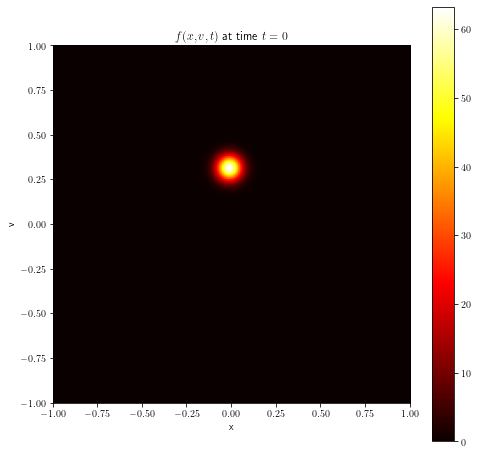

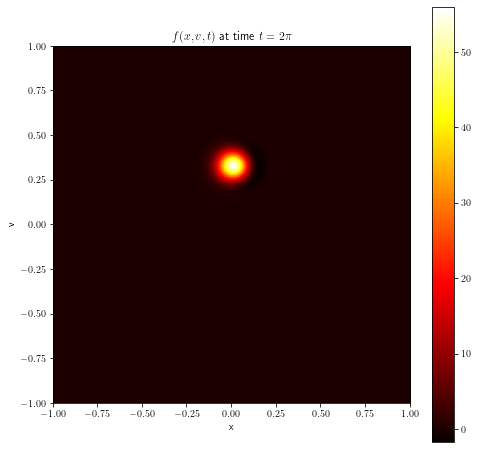

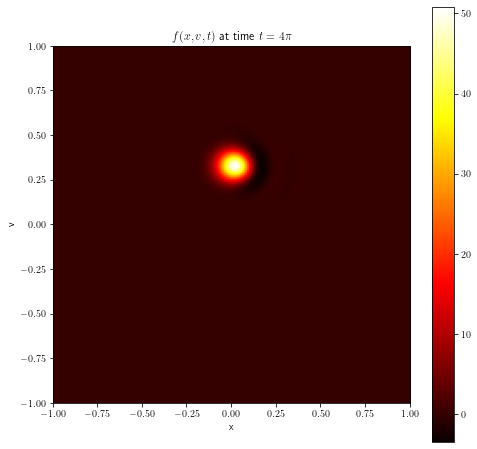

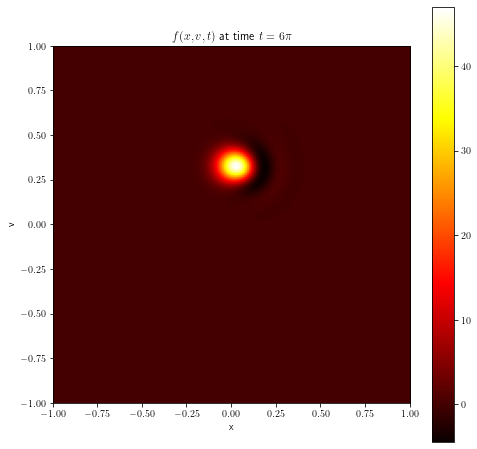

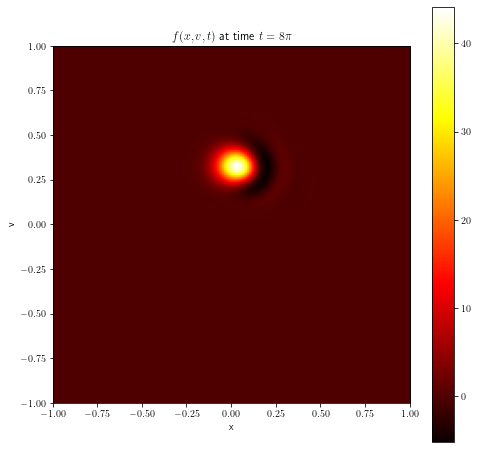

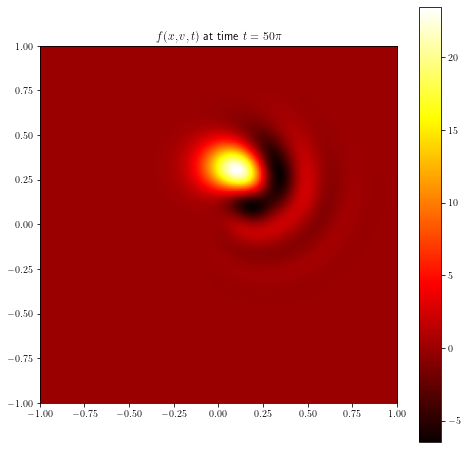

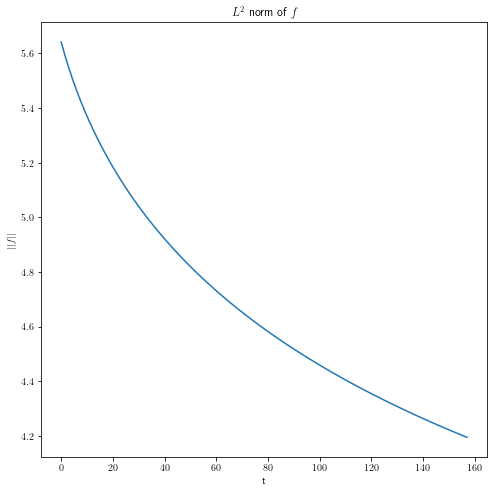

In [35]:
F = Fo(Xdgrid, Vdgrid)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

for i in range(1,5):
    F = RK2_integrate(F,K,U, dx, dv, dx/2*.8, 2*np.pi)[0]
    plt.imshow(F[0:-2,0:-2].transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {2*i}\pi$")
    plt.show()

F = Fo(Xdgrid, Vdgrid)
F, times, L2 = RK2_integrate(F,K,U, dx, dv, dx/2*.8, 50*np.pi)
plt.imshow(F[0:-2,0:-2].transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.title(f"$f(x,v,t)$ at time $t = {50}\pi$")
plt.show()

plt.plot(times,L2)
plt.title("$L^2$ norm of $f$")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.show()

We see that the solution is periodic and much less diffusive! However, we see waves forming in the direction that the distribution travels. These are the spurious oscilations predicted from the numerical dispersion relation. We need to fix this issue. We first implement a minmod flux limiter. The time integration still uses RK(2), with the edge values of $f$ limited in both the predictor and corrector step.

In [16]:
def get_minmod_slopes(F):
    """
    computes minmod limited slopes
    returns delta_{ij}^{x}, delta_{ij}^{v} as numpy arrays 
    """
    urx = np.zeros_like(F) # = \Delta u_{ij,r}^{x} * dx
    ulx = np.zeros_like(F) # = \Delta_{ij,l}^{x} * dx
    urv = np.zeros_like(F) # = \Delta_{ij,r}^{v} * dv
    ulv = np.zeros_like(F) # = \Delta_{ij,l}^{v} * dv
    
    urx[0:-1,:] = (F[1:,:] - F[0:-1,:])
    urx[-1,:] = urx[2,:] 
    ulx[1:,:] = (F[1:,:] - F[0:-1,:])
    ulx[0,:] = ulx[-3,:]
    urv[:, 0:-1] = (F[:,1:]-F[:,0:-1])
    urv[:,-1] = urv[:,2]
    ulv[:, 1:] = (F[:,1:] - F[:,0:-1])
    ulv[:,0] = ulv[:,-3]
    
    # gives sign of slope
    # gives zero if u_{l} and u_{r} have different signs 
    
    signsx = np.heaviside(urx*ulx,0) * np.sign(urx)
    signsv = np.heaviside(urv*ulv,0) * np.sign(urv)
    
    # gives minmod limited slopes 
    
    ux = signsx * np.minimum(abs(urx), abs(ulx))
    uv = signsv * np.minimum(abs(urv),abs(ulv))
    
    return ux, uv

    
def get_minmod_limited_fluxes(F, K, U):
    """
    returns upwinded, minmod limited fluxes
    inputs F, K, U 
    returns upwinded fluxes Fx, Fv are numpy arrays of size Nx+, Nv+3
    """
    ux, uv = get_minmod_slopes(F)
    
    Kp = np.maximum(0,K)
    Km = np.minimum(0,K)
    Up = np.maximum(0,U)
    Um = np.minimum(0,U)
    
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:,:] = Kp[1:,:]*(F[0:-1,:] + .5*ux[0:-1,:]) + Km[1:,:]*(F[1:,:] - .5*ux[1:,:])
    Fx[0,:] = Fx[-3,:]
    
    Fv[:, 1:] = Up[:,1:] *(F[:,0:-1] + .5*uv[:,0:-1]) + Um[:,1:]*(F[:,1:] - .5*uv[:,1:])
    Fv[:,0] = Fv[:,-3]

    return Fx, Fv


def minmod_get_k(F, K, U, dx, dv, dt):
    """
    gives k*dt for runge kutta predictor step
    """
    Fx, Fv = get_minmod_limited_fluxes(F,K,U)
    
    k = np.zeros_like(F)
    k[0:-1,0:-1] =  - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def minmod_RK2_step(F, K, U, dx, dv, dt):
    """
    corrector step for RK2
    gives f^{n+1} - f^{n}
    edge values are limited here too
    """
    
    Fx, Fv = get_minmod_limited_fluxes(F,K,U)
    
    k = np.zeros_like(F) 
    k[0:-1,0:-1] = - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def minmod_RK2_integrate(F,K,U,dx,dv,dt, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using RK(2) and a minmod limiting
    """
    num_time_steps = math.ceil(tfin/dt)
    times = dt*np.arange(num_time_steps)
    L2 = [np.linalg.norm(F[0:-3,0:-3])*math.sqrt(dx*dv)]
    
    for _ in range(num_time_steps -1):
        k2 = minmod_get_k(F,K,U, dx, dv, dt/2)
        F = F + minmod_RK2_step(F+k2, K,U, dx, dv, dt)
        L2.append(np.linalg.norm(F[0:-3,0:-3])*math.sqrt(dx*dv))
    return F, times, L2

Let us test again the simple harmonic oscilator with our minmod + RK(2) scheme. We again use the courtant number $C = .8$.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math
plt.rcParams['text.usetex'] = True

x, v = sp.symbols("x,v", real = True)

# input $H$ as a sympy function
###############################
K = v**2/2
U = -x**2/2
Ham = K - U
###############################

# input number of grid points in each dimention
################################
Nx = 200
Nv = 200
################################

#initial condition for f
################################
def Fo(X,V):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    fo = np.exp(- 200*(V-1/3)**2 - 200*(X)**2)/0.015707963267949588
    
    # inposes periodicity
    fo[-1,:] = fo[2,:]
    fo[-2,:] = fo[1,:]
    fo[-3,:] = fo[0,:]
    fo[:,-1] = fo[:,2]
    fo[:,-2] = fo[:,1]
    fo[:,-3] = fo[:,0]
    
    return fo
################################

#define grid
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1+2*dx, Nx+3) # the points x_{i}, X[0], X[-1] define the same point
V = np.linspace(-1,1+2*dx,Nv+3) # the points v_{j}, V[0], V[-1] define the same point 
Xd = X + dx/2 # the points, x_{i+1/2}
Vd = V + dv/2 # the points, v_{i+1/2}

Xgrid, Vgrid = np.meshgrid(X,V)
Xgrid = Xgrid.transpose() 
Vgrid = Vgrid.transpose()

Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
Xdgrid = Xdgrid.transpose()
Vdgrid = Vdgrid.transpose()

# creates callable function for the derivatives of H
Kv = sp.diff(K,v)
Ux = sp.diff(U,x)
K = np.zeros_like(Xgrid)
U = np.zeros_like(Xgrid)
H = np.zeros_like(Xgrid)
for i in range(Nx+3):
    for j in range(Nv+3):
        K[i,j] = Kv.subs([(x,X[i]),(v,Vd[j])])
        U[i,j] = Ux.subs([(x,Xd[i]),(v,V[j])])
        H[i,j] = Ham.subs([(x,Xd[i]),(v,Vd[j])])

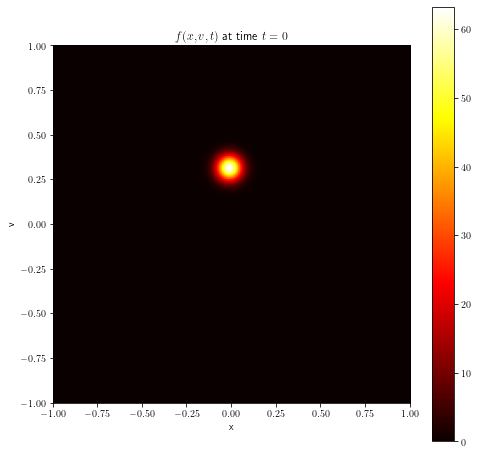

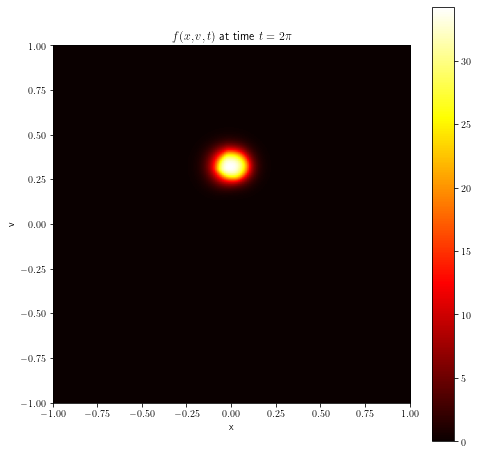

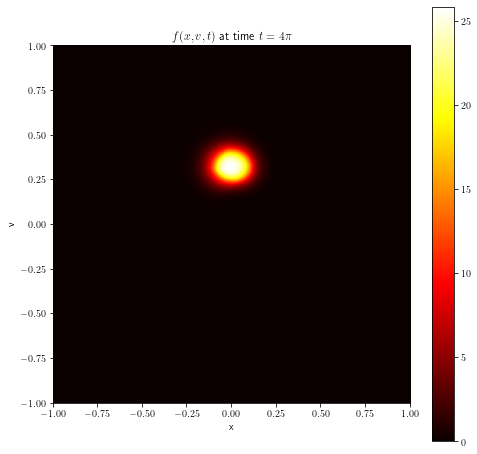

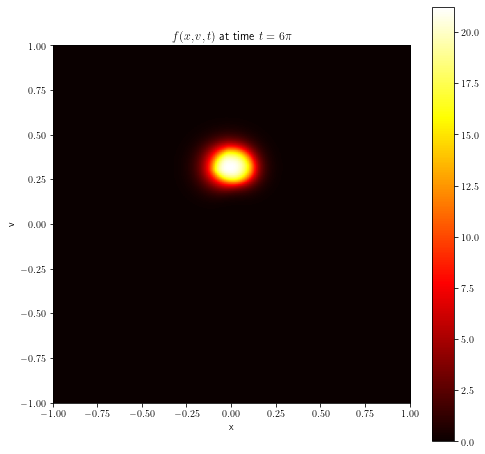

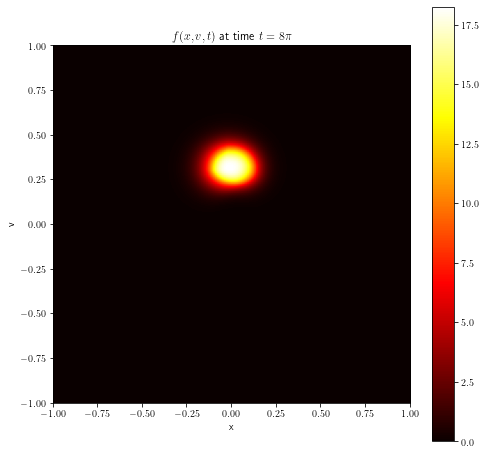

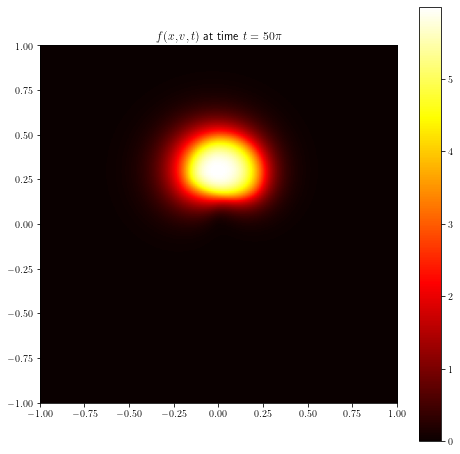

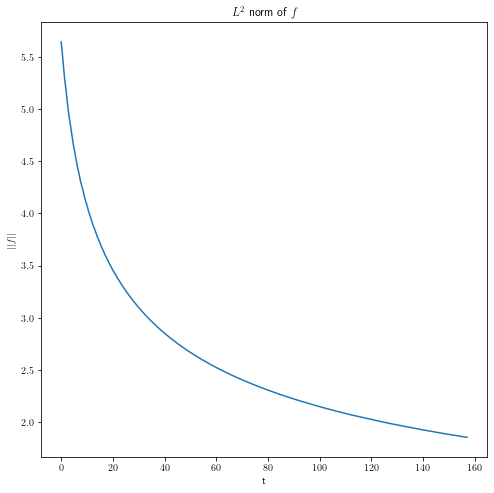

In [18]:
F = Fo(Xdgrid, Vdgrid)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

for i in range(1,5):
    F = minmod_RK2_integrate(F,K,U, dx, dv, dx/2*.8, 2*np.pi)[0]
    plt.imshow(F[0:-2,0:-2].transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {2*i}\pi$")
    plt.show()
    
 
F = Fo(Xdgrid, Vdgrid)
F, times, L2 = minmod_RK2_integrate(F,K,U, dx, dv, .8*dx/2, 50*np.pi)
plt.imshow(F[0:-2,0:-2].transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.title(f"$f(x,v,t)$ at time $t = {50}\pi$")
plt.show()

plt.plot(times,L2)
plt.title("$L^2$ norm of $f$")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.show()



Amazing! We have no oscillations The solution is perfectly positive everywhere, as our analysis suggested. Further, it appears like the diffusion is comparable to the second order Runge-Kutta scheme. The only problem with this scheme is that the minmod limiter elongates the distribution along its direction of travel. The minmod limiter also clips the distribution. This might be helped with a smooth extremum detector.

We now implement a similar scheme with moncen instead of minmod limiting. We run the same test case. 

In [19]:
def get_moncen_slopes(F):
    """
    computes moncen limited slopes times dx or dv
    returns delta_{ij}^{x}, delta_{ij}^{v} as numpy arrays 
    """
    urx = np.zeros_like(F) # = \Delta u_{ij,r}^{x} * dx
    ulx = np.zeros_like(F) # = \Delta_{ij,l}^{x} * dx
    urv = np.zeros_like(F) # = \Delta_{ij,r}^{v} * dv
    ulv = np.zeros_like(F) # = \Delta_{ij,l}^{v} * dv
    
    urx[0:-1,:] = (F[1:,:] - F[0:-1,:])
    urx[-1,:] = urx[2,:] 
    ulx[1:,:] = (F[1:,:] - F[0:-1,:])
    ulx[0,:] = ulx[-3,:]
    urv[:, 0:-1] = (F[:,1:]-F[:,0:-1])
    urv[:,-1] = urv[:,2]
    ulv[:, 1:] = (F[:,1:] - F[:,0:-1])
    ulv[:,0] = ulv[:,-3]
    
    ucx = (urx+ulx)/2 # average slops
    ucv = (urv + ulv)/2 
    
    # gives sign of slope
    # gives zero if u_{l} and u_{r} have different signs 
    
    signsx = np.heaviside(urx*ulx,0) * np.sign(urx)
    signsv = np.heaviside(urv*ulv,0) * np.sign(urv)
    
    # gives minmod limited slopes 
    
    ux = signsx * np.minimum(np.minimum(2*abs(urx), 2*abs(ulx)), abs(ucx))
    uv = signsv * np.minimum(np.minimum(2*abs(urv),2*abs(ulv)), abs(ucv))
    
    return ux, uv


    
def get_moncen_limited_fluxes(F, K, U):
    """
    returns upwinded, moncen limited fluxes
    inputs F, K, U 
    returns upwinded fluxes Fx, Fv are numpy arrays of size Nx+, Nv+3
    """
    ux, uv = get_moncen_slopes(F)
    
    Kp = np.maximum(0,K)
    Km = np.minimum(0,K)
    Up = np.maximum(0,U)
    Um = np.minimum(0,U)
    
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:,:] = Kp[1:,:]*(F[0:-1,:] + .5*ux[0:-1,:]) + Km[1:,:]*(F[1:,:] - .5*ux[1:,:])
    Fx[0,:] = Fx[-3,:]
    
    Fv[:, 1:] = Up[:,1:] *(F[:,0:-1] + .5*uv[:,0:-1]) + Um[:,1:]*(F[:,1:] - .5*uv[:,1:])
    Fv[:,0] = Fv[:,-3]

    return Fx, Fv


def moncen_get_k(F, K, U, dx, dv, dt):
    """
    gives k*dt for runge kutta predictor step
    """
    Fx, Fv = get_moncen_limited_fluxes(F,K,U)
    
    k = np.zeros_like(F)
    k[0:-1,0:-1] =  -dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def moncen_RK2_step(F, K, U, dx, dv, dt):
    """
    corrector step for RK2 
    edge values are limited here too
    """
    
    Fx, Fv = get_moncen_limited_fluxes(F,K,U)
    k = np.zeros_like(F)
    k[0:-1,0:-1] = - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def moncen_RK2_integrate(F,K,U,dx,dv,dt, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using RK(2) and a moncen limiting
    returns a numpy array of $f(t_{n})$
    """
    num_time_steps = math.ceil(tfin/dt)
    times = dt*np.arange(num_time_steps)
    L2 = [np.linalg.norm(F[0:-3,0:-3])*math.sqrt(dx*dv)]
    
    for _ in range(num_time_steps -1):
        k2 = moncen_get_k(F,K,U, dx, dv, dt/2)
        F = F + moncen_RK2_step(F+k2, K,U, dx, dv, dt)
        L2.append(np.linalg.norm(F[0:-3,0:-3])*math.sqrt(dx*dv))
        
    return F, times, L2

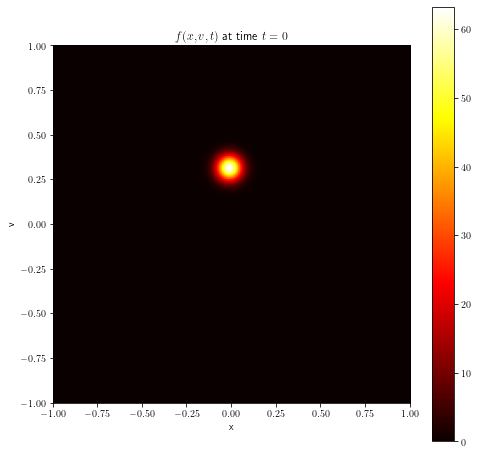

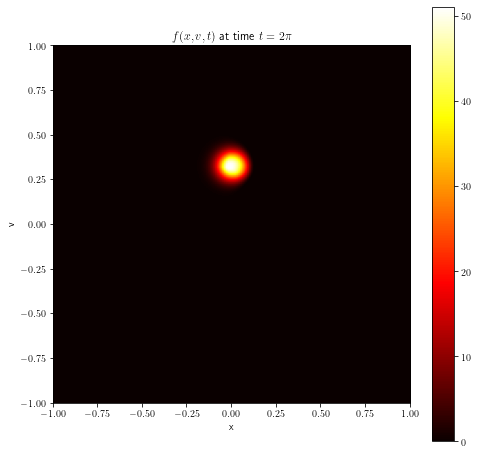

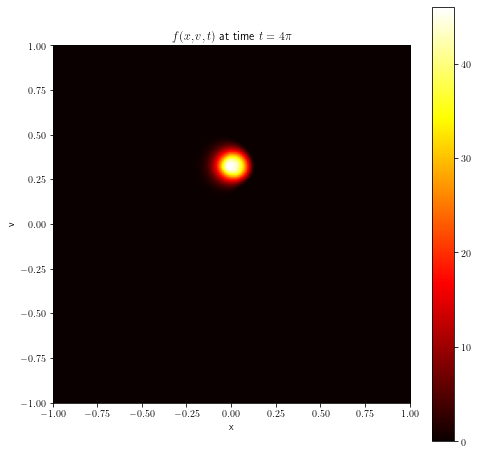

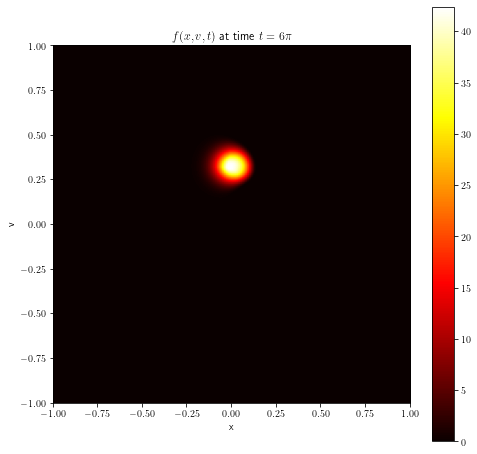

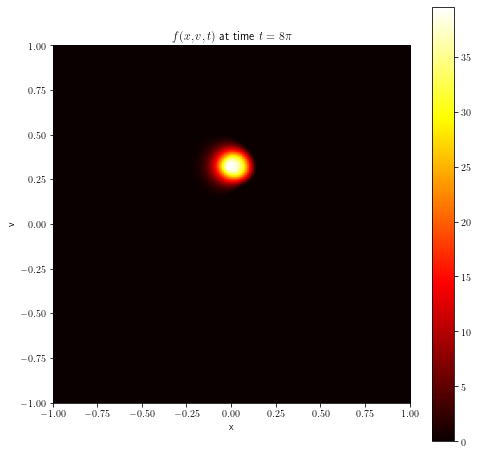

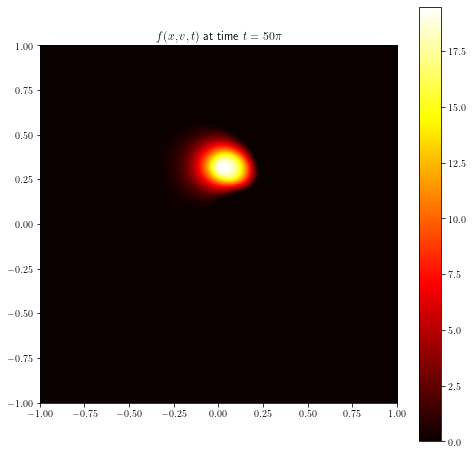

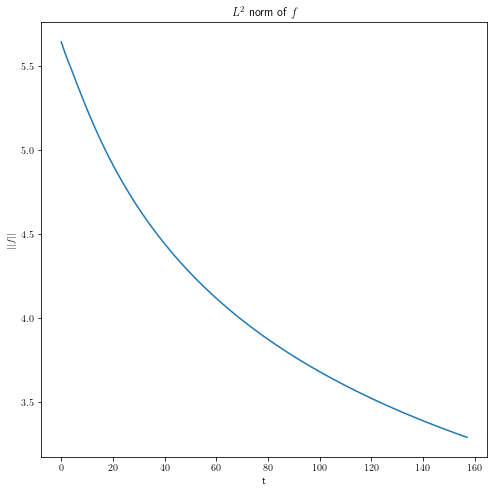

In [20]:
F = Fo(Xdgrid, Vdgrid)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

for i in range(1,5):
    F = moncen_RK2_integrate(F,K,U, dx, dv, dx/2*.8, 2*np.pi)[0]
    plt.imshow(F[0:-2,0:-2].transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {2*i}\pi$")
    plt.show()
   
F = Fo(Xdgrid, Vdgrid)
F, times, L2 = moncen_RK2_integrate(F,K,U, dx, dv, .8*dx/2, 50*np.pi)
plt.imshow(F[0:-2,0:-2].transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.title(f"$f(x,v,t)$ at time $t = {50}\pi$")
plt.show()

plt.plot(times,L2)
plt.title("$L^2$ norm of $f$")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.show()



The Moncen limiter is almost perfect! It seems to be more accurate than the minmod limiter, while still preserving the positivity of $f$ and preventing oscilations. 

The final scheme we implement is the MUSCL-Handcock-like scheme (except without a smooth extremum detector). In this scheme, we use moncen to limit the slope of the RK(2) prediction step, and then use the upwind value of $f$ to get the fluxes on the corrector step. 

In [21]:
def get_moncen_slopes(F):
    """
    computes moncen limited slopes times dx or dv
    returns delta_{ij}^{x}, delta_{ij}^{v} as numpy arrays 
    """
    urx = np.zeros_like(F) # = \Delta u_{ij,r}^{x} * dx
    ulx = np.zeros_like(F) # = \Delta_{ij,l}^{x} * dx
    urv = np.zeros_like(F) # = \Delta_{ij,r}^{v} * dv
    ulv = np.zeros_like(F) # = \Delta_{ij,l}^{v} * dv
    
    urx[0:-1,:] = (F[1:,:] - F[0:-1,:])
    urx[-1,:] = urx[2,:] 
    ulx[1:,:] = (F[1:,:] - F[0:-1,:])
    ulx[0,:] = ulx[-3,:]
    urv[:, 0:-1] = (F[:,1:]-F[:,0:-1])
    urv[:,-1] = urv[:,2]
    ulv[:, 1:] = (F[:,1:] - F[:,0:-1])
    ulv[:,0] = ulv[:,-3]
    
    ucx = (urx+ulx)/2 # average slops
    ucv = (urv + ulv)/2 
    
    # gives sign of slope
    # gives zero if u_{l} and u_{r} have different signs 
    
    signsx = np.heaviside(urx*ulx,0) * np.sign(urx)
    signsv = np.heaviside(urv*ulv,0) * np.sign(urv)
    
    # gives minmod limited slopes 
    
    ux = signsx * np.minimum(np.minimum(2*abs(urx), 2*abs(ulx)), abs(ucx))
    uv = signsv * np.minimum(np.minimum(2*abs(urv),2*abs(ulv)), abs(ucv))
    
    return ux, uv

    
def get_moncen_limited_fluxes(F, K, U):
    """
    returns upwinded, minmod limited fluxes
    inputs F, K, U 
    returns upwinded fluxes Fx, Fv are numpy arrays of size Nx+, Nv+3
    """
    ux, uv = get_moncen_slopes(F)
    
    Kp = np.maximum(0,K)
    Km = np.minimum(0,K)
    Up = np.maximum(0,U)
    Um = np.minimum(0,U)
    
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:,:] = Kp[1:,:]*(F[0:-1,:] + .5*ux[0:-1,:]) + Km[1:,:]*(F[1:,:] - .5*ux[1:,:])
    Fx[0,:] = Fx[-3,:]
    
    Fv[:, 1:] = Up[:,1:] *(F[:,0:-1] + .5*uv[:,0:-1]) + Um[:,1:]*(F[:,1:] - .5*uv[:,1:])
    Fv[:,0] = Fv[:,-3]

    return Fx, Fv

def get_upwind_fluxes(F, K, U):
    """
    Gives the upwinded fluxes at each timestep
    
    inputs F,K, U 
    returns fluxes Fx, Fv as numpy arrays
    """
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:, :] = K[1:,:]*(F[1:,:] + F[0:-1,:])/2 - abs(K[1:,:])*(F[1:,:] -  F[0:-1,:])/2
    Fv[:, 1:] = U[:,1:]*(F[:,1:]+ F[:,0:-1])/2 - abs(U[:,1:])*(F[:,1:]- F[:,0:-1])/2
    Fx[0,:] = Fx[-1,:]
    Fv[:,0] = Fv[:,-1]
    return Fx, Fv


def muscl_get_k(F, K, U, dx, dv, dt):
    """
    gives k*dt for MUSCL predictor step
    """
    Fx, Fv = get_moncen_limited_fluxes(F,K,U)
    
    k = np.zeros_like(F)
    k[0:-1,0:-1] =  -dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def muscl_RK2_step(F, K, U, dx, dv, dt):
    """
    corrector step for RK2 
    edge values are obtained by upwinding
    """
    
    Fx, Fv = get_upwind_fluxes(F,K,U)
    k = np.zeros_like(F)
    k[0:-1,0:-1] = - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def muscl_integrate(F,K,U,dx,dv,dt, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using MUSCL-Handcock like scheme
    """
    num_time_steps = math.ceil(tfin/dt)
    times = dt*np.arange(num_time_steps)
    L2 = [np.linalg.norm(F[0:-3,0:-3])*math.sqrt(dx*dv)]
    
    for _ in range(num_time_steps -1):
        k2 = muscl_get_k(F,K,U, dx, dv, dt/2)
        F = F + muscl_RK2_step(F+k2, K,U, dx, dv, dt)
        L2.append(np.linalg.norm(F[0:-3,0:-3])*math.sqrt(dx*dv))
        
    return F, times, L2

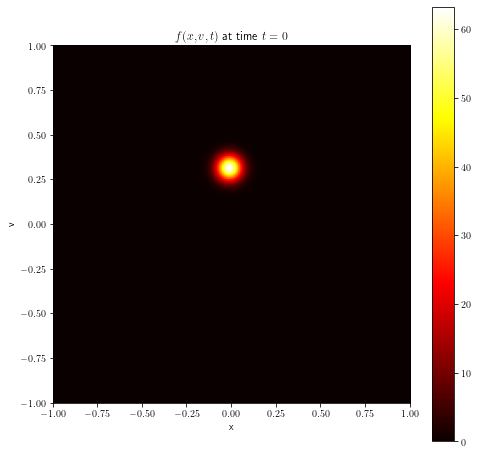

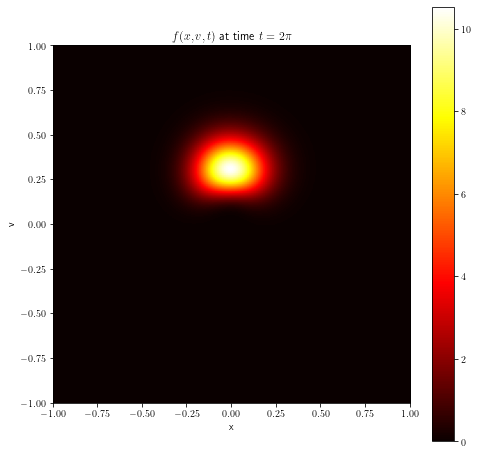

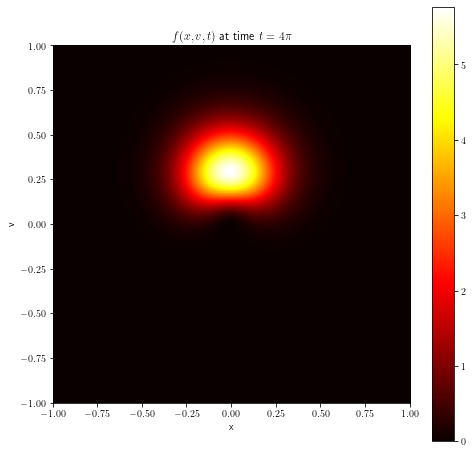

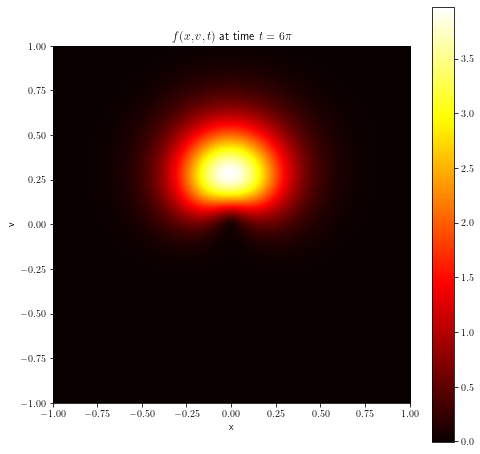

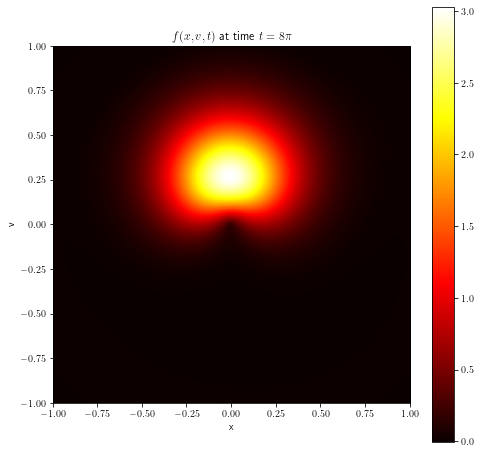

In [22]:
F = Fo(Xdgrid, Vdgrid)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

for i in range(1,5):
    F = muscl_integrate(F,K,U, dx, dv, dx/2*.8, 2*np.pi)[0]
    plt.imshow(F[0:-2,0:-2].transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {2*i}\pi$")
    plt.show()
    
    

We see that the Muscl-Handcock is quite diffusive. But stable and positivity preserving. This makes sense since we do a peicewise-constant reconstruction of $f^{n+1/2}$. It seems our RK(2) schemes with flux limiting work the best. Let ia simulate the true Vlasov equations with our RK(2) + limiting scheme. We use Fourier interpolation to get the electric field. We make two solvers, one using moncen limiting, and one using minmod limiting.

In [23]:
def get_Fo(Nx,Nv):
    """
    initial conditions for f
    """
    dx = 2/Nx
    dv = 2/Nv
    X = np.linspace(-1,1+2*dx, Nx+3) # the points x_{i}, X[0], X[-1] define the same point
    V = np.linspace(-1,1+2*dx,Nv+3) # the points v_{j}, V[0], V[-1] define the same point 
    Xd = X + dx/2 # the points, x_{i+1/2}
    Vd = V + dv/2 # the points, v_{i+1/2}

    Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
    X = Xdgrid.transpose()
    V = Vdgrid.transpose()

    fo = 10*(10+np.sin(2*np.pi*X))*(np.exp(- 1000*(V-.2)**2)+np.exp(- 1000*(V+.3)**2))
    
    # inposes periodicity
    fo[-1,:] = fo[2,:]
    fo[-2,:] = fo[1,:]
    fo[-3,:] = fo[0,:]
    fo[:,-1] = fo[:,2]
    fo[:,-2] = fo[:,1]
    fo[:,-3] = fo[:,0]
    
    return fo

def get_charge(F, dx, dv):
    """
    returns C(x_{i}) as numpy array
    """
    n = dv*np.sum(F[:,0:-3],axis = 1)
    C = dx*np.sum(n[0:-3])/2
    return n - C

def get_K(Nx, Nv):
    """
    return K array
    """
    #define grid
    dx = 2/Nx
    dv = 2/Nv
    X = np.linspace(-1,1+2*dx, Nx+3)
    Vd = np.linspace(-1,1+2*dv, Nv+3)+1/(Nv) 
    K = np.meshgrid(X,Vd)[1].transpose()
    #K[-1,:] = K[2,:]
    #K[:,-1] = K[:,2]
    return K

def get_E(F,dx,dv):
    """
    returns E(x_{i}) as numpy array
    """
    n = dv*np.sum(F[:,0:-3],axis = 1)
    C = dx*np.sum(n[0:-3])/2
    E = np.zeros_like(n)
    l = len(n)-3
    for i in range(l-1):
        E[i+1] = E[i] + dx*(C-n[i])
    E[-3] = E[0]
    E[-2] = E[1]
    E[-1] = E[2]
    mean = np.sum(E[0:-3])/l
    return E - mean

def E_interp(E, Nx, Nv):
    """
    interpolates E(x_{i}) to E(x_{i+1/2}) and returns an array
    using kernel $x_{i},x_{i+1}
    """
    i = complex(0,1)
    Eint = np.empty(Nx+3)
    exp_freq = np.exp(i*np.pi*fftfreq(Nx))
    Ek = fft(E[0:-1])
    Eint[0:-3] = np.real(ifft(fft(E[0:-3])*exp_freq))
    Eint[-3]=Eint[0]
    Eint[-2]= Eint[1]
    Eint[-1] = Eint[2]
    V = np.empty(Nv+3)
    return np.meshgrid(Eint,V)[0].transpose()

def vlasov_get_moncen_slopes(F):
    """
    computes moncen limited slopes times dx or dv
    returns delta_{ij}^{x}, delta_{ij}^{v} as numpy arrays 
    """
    urx = np.zeros_like(F) # = \Delta u_{ij,r}^{x} * dx
    ulx = np.zeros_like(F) # = \Delta_{ij,l}^{x} * dx
    urv = np.zeros_like(F) # = \Delta_{ij,r}^{v} * dv
    ulv = np.zeros_like(F) # = \Delta_{ij,l}^{v} * dv
    
    urx[0:-1,:] = (F[1:,:] - F[0:-1,:])
    urx[-1,:] = urx[2,:] 
    ulx[1:,:] = (F[1:,:] - F[0:-1,:])
    ulx[0,:] = ulx[-3,:]
    urv[:, 0:-1] = (F[:,1:]-F[:,0:-1])
    urv[:,-1] = urv[:,2]
    ulv[:, 1:] = (F[:,1:] - F[:,0:-1])
    ulv[:,0] = ulv[:,-3]
    
    ucx = (urx+ulx)/2 # average slopes
    ucv = (urv + ulv)/2 
    
    # gives sign of slope
    # gives zero if u_{l} and u_{r} have different signs 
    
    signsx = np.heaviside(urx*ulx,0) * np.sign(urx)
    signsv = np.heaviside(urv*ulv,0) * np.sign(urv)
    
    # gives minmod limited slopes 
    
    ux = signsx * np.minimum(np.minimum(2*abs(urx), 2*abs(ulx)), abs(ucx))
    uv = signsv * np.minimum(np.minimum(2*abs(urv),2*abs(ulv)), abs(ucv))
    
    
    return ux, uv
    
    
def vlasov_get_moncen_limited_fluxes(F, K, E, Nx, Nv):
    """
    inputs F, K, U 
    returns upwinded fluxes Fx, Fv are numpy arrays of size Nx+3, Nv+3
    """
    U = -E_interp(E, Nx, Nv)
    
    ux, uv = vlasov_get_moncen_slopes(F)
    
    Kp = np.maximum(0,K)
    Km = np.minimum(0,K)
    Up = np.maximum(0,U)
    Um = np.minimum(0,U)
    
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:,:] = Kp[1:,:]*(F[0:-1,:] + .5*ux[0:-1,:]) + Km[1:,:]*(F[1:,:] - .5*ux[1:,:])
    Fx[0,:] = Fx[-3,:]
    
    Fv[:, 1:] = Up[:,1:] *(F[:,0:-1] + .5*uv[:,0:-1]) + Um[:,1:]*(F[:,1:] - .5*uv[:,1:])
    Fv[:,0] = Fv[:,-3]

    return Fx, Fv


def vlasov_moncen_get_k(F, K, E, Nv, dx, dv, dt):
    """
    gives k*dt
    """
    Fx, Fv = vlasov_get_moncen_limited_fluxes(F,K,E, Nx, Nv)
    k = np.zeros_like(F)
    k[0:-1,0:-1] =  - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def vlasov_moncen_integrate(F,Nx,Nv, tfin, c=.8):
    """
    integrates the vlasov equation with a fixed hamiltonian using RK(2) and a Fromm-like scheme
    returns a numpy array of $f(t_{n})$, times, L1, L2 
    """
    K = get_K(Nx,Nv)
    time = 0
    dx = 2/Nx
    dv = 2/Nv
    E = get_E(F,dx,dv)
    b = np.max(E)
    a = 1
    dt = c/(1/dx + b/dv) # c is the courant number
    while time < tfin:
        k2 = vlasov_moncen_get_k(F,K,E,Nv, dx, dv, dt/2)
        E = get_E(F,dx,dv)
        b = np.max(E)
        if 1/(1/dx + b/dv) > 1:
            dt = dt/2
            continue
        F = F + vlasov_moncen_get_k(F+k2,K,E,Nv, dx, dv, dt)
        E = get_E(F,dx,dv)
        b = np.max(E)
        dt = c/(1/dx + b/dv) # c is the courant number
        time += dt
    return F

In [24]:
from scipy.fft import fft, ifft, fftfreq

def get_Fo(Nx,Nv):
    """
    initial conditions for f
    """
    dx = 2/Nx
    dv = 2/Nv
    X = np.linspace(-1,1+2*dx, Nx+3) # the points x_{i}, X[0], X[-1] define the same point
    V = np.linspace(-1,1+2*dx,Nv+3) # the points v_{j}, V[0], V[-1] define the same point 
    Xd = X + dx/2 # the points, x_{i+1/2}
    Vd = V + dv/2 # the points, v_{i+1/2}

    Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
    X = Xdgrid.transpose()
    V = Vdgrid.transpose()

    fo = 10*(10+np.sin(2*np.pi*X))*(np.exp(- 1000*(V-.2)**2)+np.exp(- 1000*(V+.3)**2))
    
    # inposes periodicity
    fo[-1,:] = fo[2,:]
    fo[-2,:] = fo[1,:]
    fo[-3,:] = fo[0,:]
    fo[:,-1] = fo[:,2]
    fo[:,-2] = fo[:,1]
    fo[:,-3] = fo[:,0]
    
    return fo

def get_charge(F, dx, dv):
    """
    returns C(x_{i}) as numpy array
    """
    n = dv*np.sum(F[:,0:-3],axis = 1)
    C = dx*np.sum(n[0:-3])/2
    return n - C

def get_K(Nx, Nv):
    """
    return K array
    """
    #define grid
    dx = 2/Nx
    dv = 2/Nv
    X = np.linspace(-1,1+2*dx, Nx+3)
    Vd = np.linspace(-1,1+2*dv, Nv+3)+1/(Nv) 
    K = np.meshgrid(X,Vd)[1].transpose()
    return K

def get_E(F,dx,dv):
    """
    returns E(x_{i}) as numpy array
    """
    n = dv*np.sum(F[:,0:-3],axis = 1)
    C = dx*np.sum(n[0:-3])/2
    E = np.zeros_like(n)
    l = len(n)-3
    for i in range(l-1):
        E[i+1] = E[i] + dx*(C-n[i])
    E[-3] = E[0]
    E[-2] = E[1]
    E[-1] = E[2]
    mean = np.sum(E[0:-3])/l
    return E - mean


def E_interp(E, Nx, Nv):
    """
    interpolates E(x_{i}) to E(x_{i+1/2}) and returns an array
    using kernel $x_{i},x_{i+1}
    """
    i = complex(0,1)
    Eint = np.empty(Nx+3)
    exp_freq = np.exp(i*np.pi*fftfreq(Nx))
    Ek = fft(E[0:-1])
    Eint[0:-3] = np.real(ifft(fft(E[0:-3])*exp_freq))
    Eint[-3]=Eint[0]
    Eint[-2]= Eint[1]
    Eint[-1] = Eint[2]
    V = np.empty(Nv+3)
    return np.meshgrid(Eint,V)[0].transpose()


def vlasov_get_minmod_slopes(F):
    """
    computes moncen limited slopes times dx or dv
    returns delta_{ij}^{x}, delta_{ij}^{v} as numpy arrays 
    """
    urx = np.zeros_like(F) # = \Delta u_{ij,r}^{x} * dx
    ulx = np.zeros_like(F) # = \Delta_{ij,l}^{x} * dx
    urv = np.zeros_like(F) # = \Delta_{ij,r}^{v} * dv
    ulv = np.zeros_like(F) # = \Delta_{ij,l}^{v} * dv
    
    urx[0:-1,:] = (F[1:,:] - F[0:-1,:])
    urx[-1,:] = urx[2,:] 
    ulx[1:,:] = (F[1:,:] - F[0:-1,:])
    ulx[0,:] = ulx[-3,:]
    urv[:, 0:-1] = (F[:,1:]-F[:,0:-1])
    urv[:,-1] = urv[:,2]
    ulv[:, 1:] = (F[:,1:] - F[:,0:-1])
    ulv[:,0] = ulv[:,-3]
    
    
    # gives sign of slope
    # gives zero if u_{l} and u_{r} have different signs 
    
    signsx = np.heaviside(urx*ulx,0) * np.sign(urx)
    signsv = np.heaviside(urv*ulv,0) * np.sign(urv)
    
    #gives minmod limited slopes
    
    ux = signsx * np.minimum(abs(urx), 2*abs(ulx))
    uv = signsv * np.minimum(2*abs(urv),2*abs(ulv))
    
    return ux, uv
    
    
def vlasov_get_minmod_limited_fluxes(F, K, E, Nx, Nv):
    """
    inputs F, K, U 
    returns upwinded fluxes Fx, Fv are numpy arrays of size Nx+, Nv+3
    """
    U = -E_interp(E,Nx,Nv)
    
    ux, uv = vlasov_get_minmod_slopes(F)
    
    Kp = np.maximum(0,K)
    Km = np.minimum(0,K)
    Up = np.maximum(0,U)
    Um = np.minimum(0,U)
    
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:,:] = Kp[1:,:]*(F[0:-1,:] + .5*ux[0:-1,:]) + Km[1:,:]*(F[1:,:] - .5*ux[1:,:])
    Fx[0,:] = Fx[-3,:]
    
    Fv[:, 1:] = Up[:,1:] *(F[:,0:-1] + .5*uv[:,0:-1]) + Um[:,1:]*(F[:,1:] - .5*uv[:,1:])
    Fv[:,0] = Fv[:,-3]

    return Fx, Fv


def vlasov_minmod_get_k(F, K, E, Nv, dx, dv, dt):
    """
    gives k*dt
    """
    Fx, Fv = vlasov_get_minmod_limited_fluxes(F,K,E, Nx, Nv)
    k = np.zeros_like(F)
    k[0:-1,0:-1] =  - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    k[-1,0:-1] = k[2,0:-1]
    k[0:-1,-1] = k[0:-1,2]
    k[-1,-1] = k[2,2]
    
    return k

def vlasov_minmod_integrate(F,Nx,Nv, tfin, c= .8):
    """
    integrates the vlasov equation with a fixed hamiltonian using RK(2) and a Fromm-like scheme
    returns a numpy array of $f(t_{n})$, times, L1, L2 
    """
    K = get_K(Nx,Nv)
    time = 0
    dx = 2/Nx
    dv = 2/Nv
    E = get_E(F,dx,dv)
    b = np.max(E)
    a = 1
    dt = c/(1/dx + b/dv) # c is the courant number
    while time < tfin:
        k2 = vlasov_minmod_get_k(F,K,E,Nv, dx, dv, dt/2)
        E = get_E(F,dx,dv)
        b = np.max(E)
        if 1/(1/dx + b/dv) > 1:
            dt = dt/2
            continue
        F = F + vlasov_minmod_get_k(F+k2,K,E,Nv, dx, dv, dt)
        E = get_E(F,dx,dv)
        b = np.max(E)
        dt = c/(1/dx + b/dv) # c is the courant number
        time += dt
    return F

We now simulate the two stream instability with $k = 8 \pi$ using both moncen and minmod limiters. We should have a stable system in both cases.

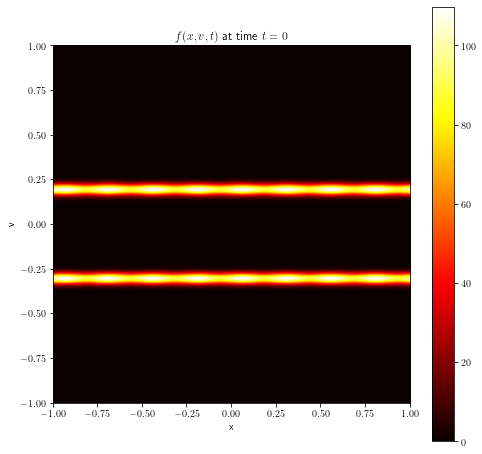

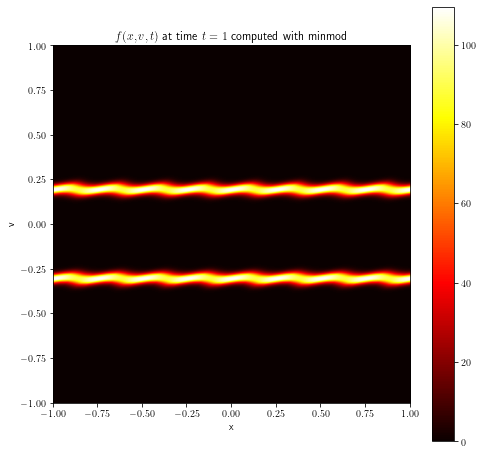

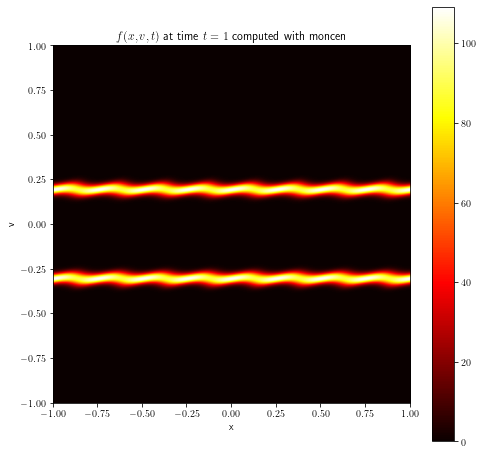

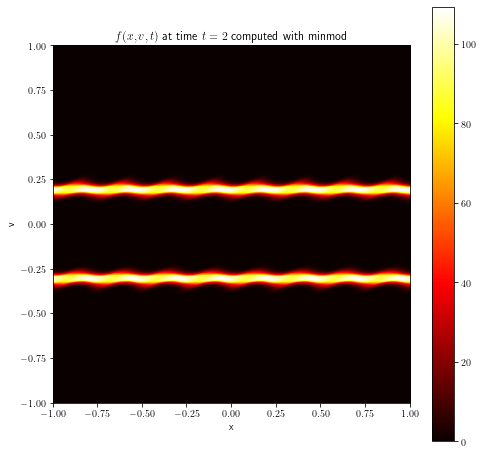

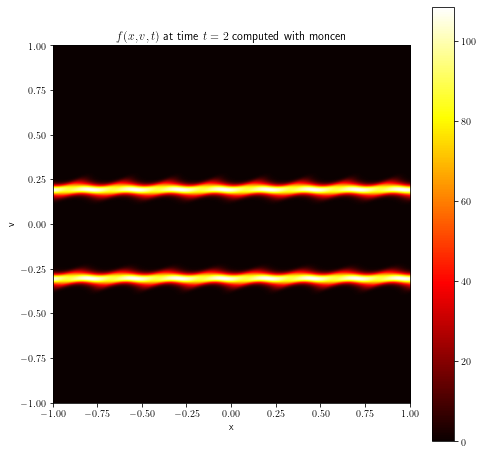

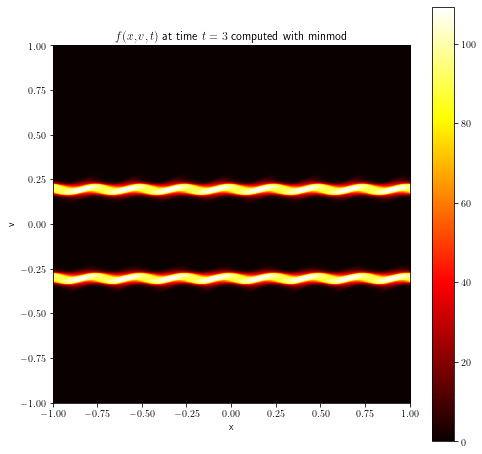

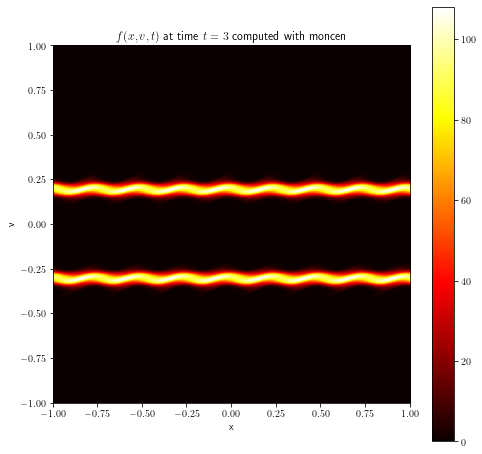

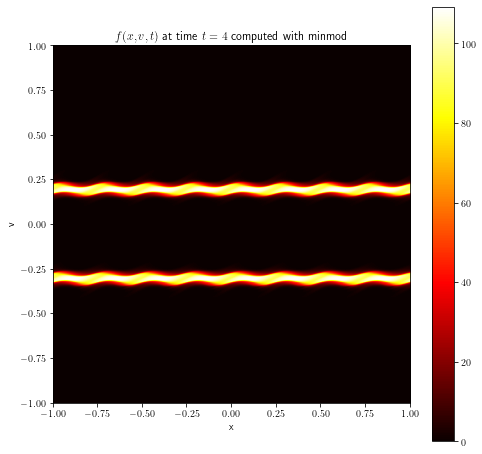

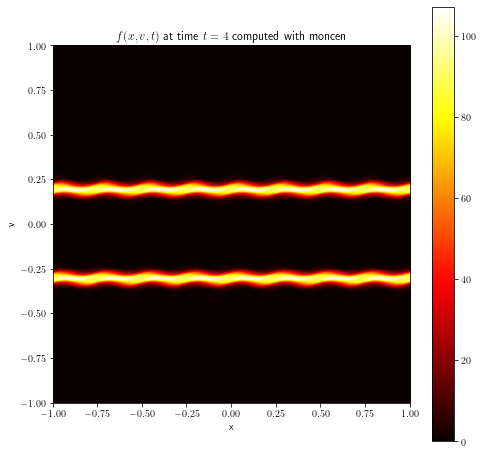

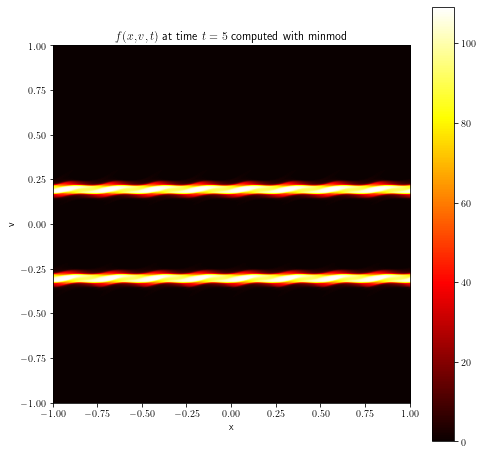

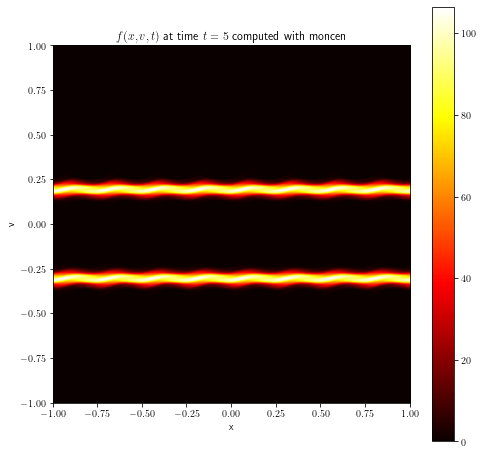

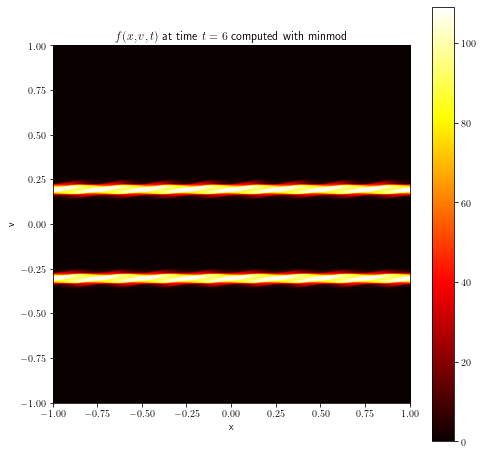

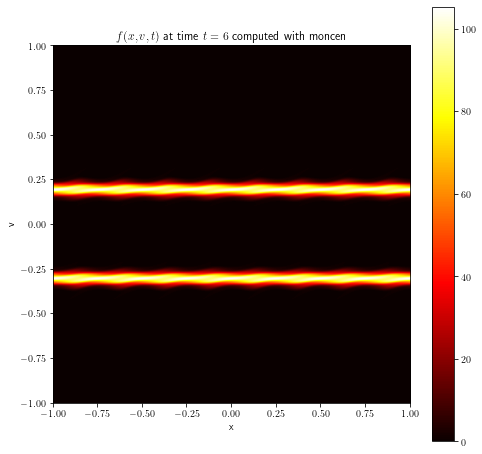

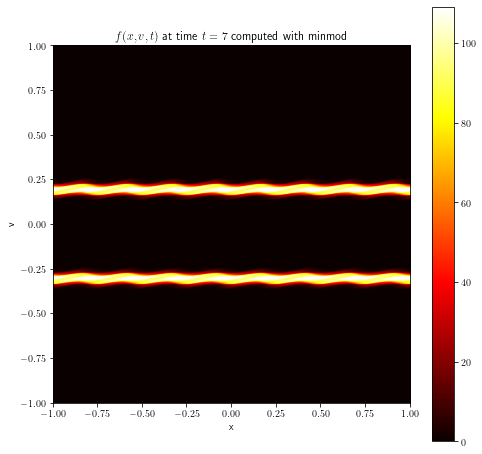

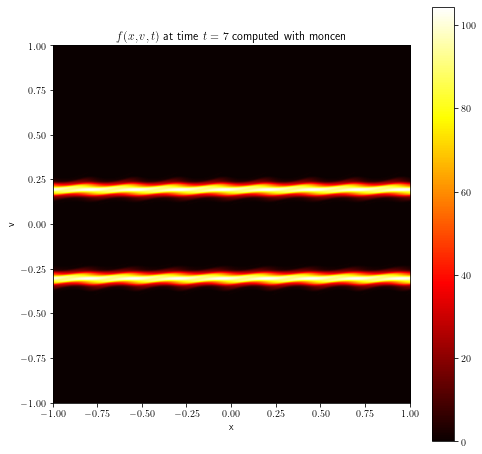

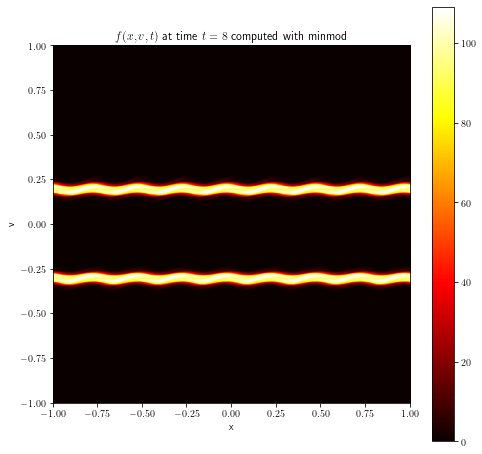

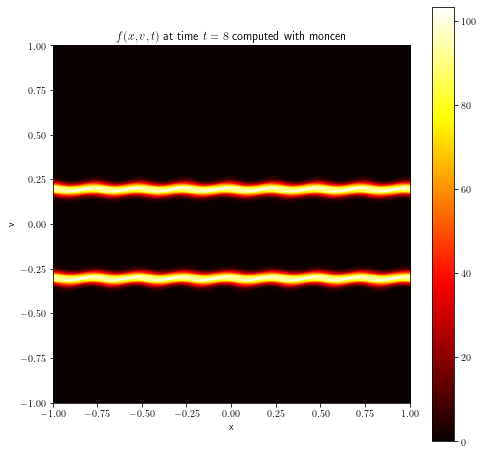

In [25]:
def get_Fo(Nx,Nv):
    """
    initial conditions for f
    """
    dx = 2/Nx
    dv = 2/Nv
    X = np.linspace(-1,1+2*dx, Nx+3) # the points x_{i}, X[0], X[-1] define the same point
    V = np.linspace(-1,1+2*dx,Nv+3) # the points v_{j}, V[0], V[-1] define the same point 
    Xd = X + dx/2 # the points, x_{i+1/2}
    Vd = V + dv/2 # the points, v_{i+1/2}

    Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
    X = Xdgrid.transpose()
    V = Vdgrid.transpose()

    fo = 10*(10+np.sin(8*np.pi*X))*(np.exp(- 1000*(V-.2)**2)+np.exp(- 1000*(V+.3)**2))
    
    # inposes periodicity
    fo[-1,:] = fo[2,:]
    fo[-2,:] = fo[1,:]
    fo[-3,:] = fo[0,:]
    fo[:,-1] = fo[:,2]
    fo[:,-2] = fo[:,1]
    fo[:,-3] = fo[:,0]
    
    return fo

Nx = 512
Ny = 512
Times = [0,1,2,3,4,5,6,7,8]
x = np.linspace(-1,1,Nx+1) + 1/Nx
Fminmod = get_Fo(Nx,Ny)
Fmoncen = get_Fo(Nx,Ny)
plt.imshow(Fminmod.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

for i in range(1,len(Times)):
    Fminmod = vlasov_minmod_integrate(Fminmod,Nx, Ny, Times[i]-Times[i-1])
    Fmoncen = vlasov_moncen_integrate(Fmoncen,Nx, Ny, Times[i]-Times[i-1])
    
    plt.imshow(Fminmod.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {Times[i]}$ computed with minmod")
    plt.show()
    
    plt.imshow(Fmoncen.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {Times[i]}$ computed with moncen")
    plt.show()


We see that both our minmod and moncen limited solvers predict that the plasma is stable, and that $f$ is nonnegative. Further, both methods do not dissipate the sinusoidal perturbation to the plasma. However, we see that the minmod and moncen limiters are qualitatively different. With minmod limitting, the distribution plateaus whereas with moncen the distribution is more smoothly varying. 

We now simulate the two stream instability with $k = 2 \pi$. 

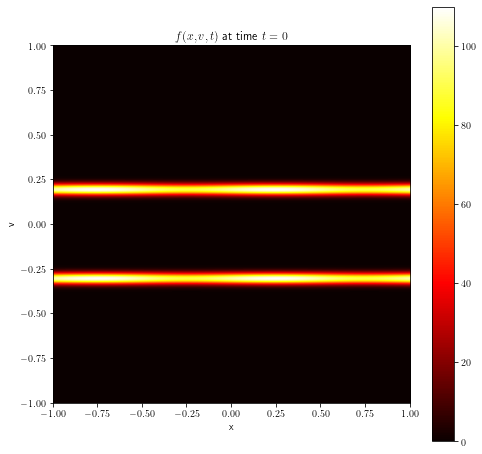

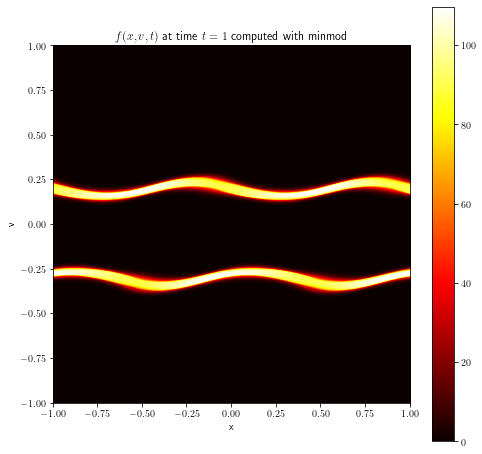

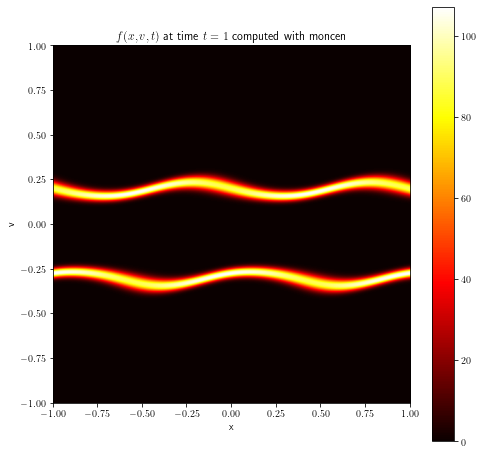

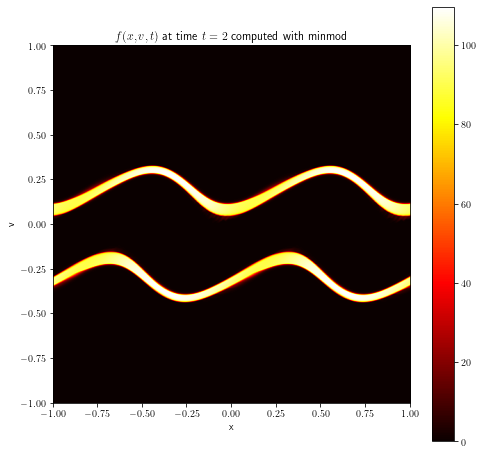

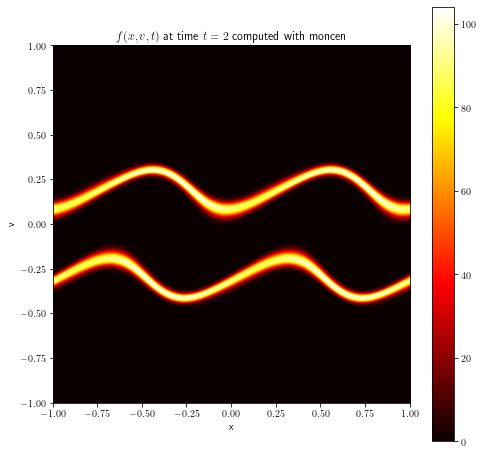

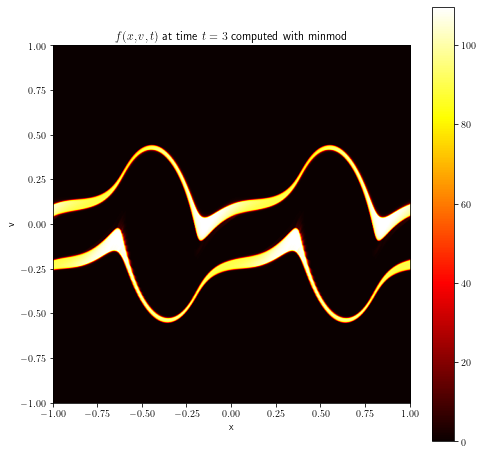

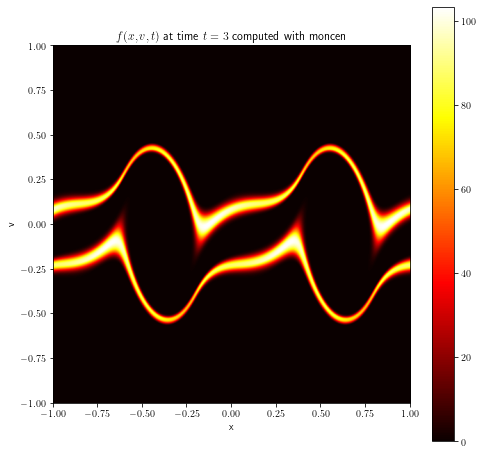

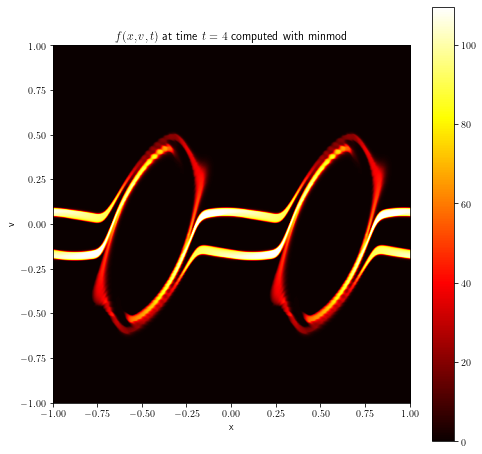

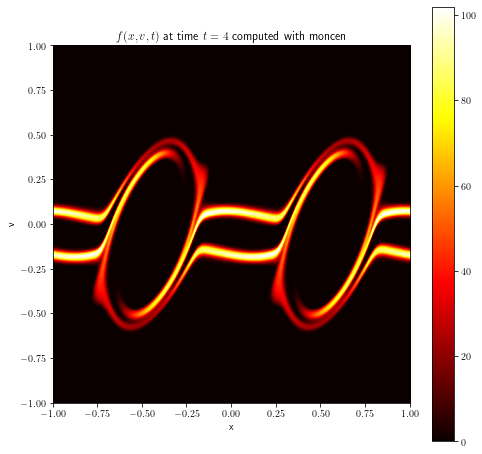

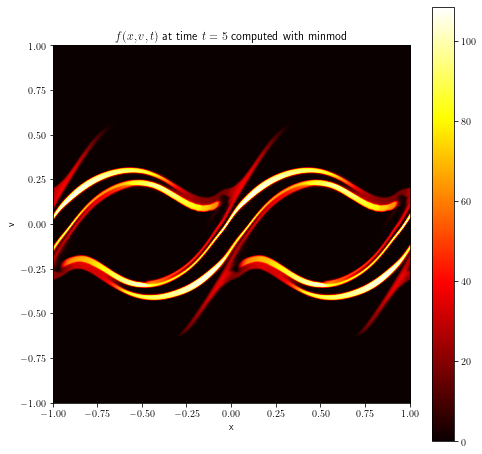

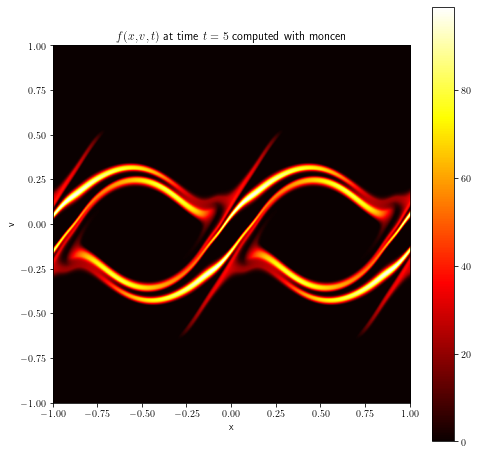

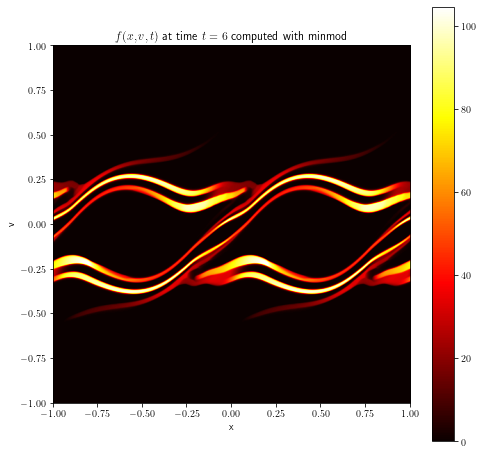

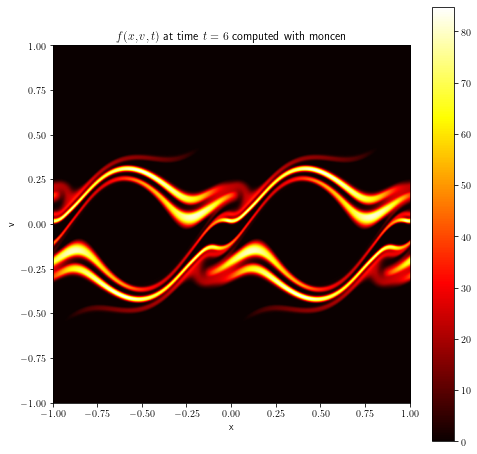

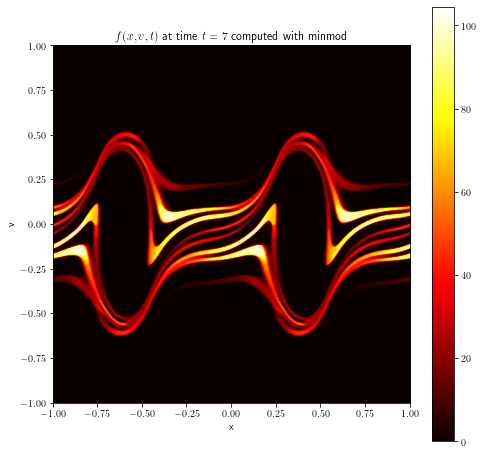

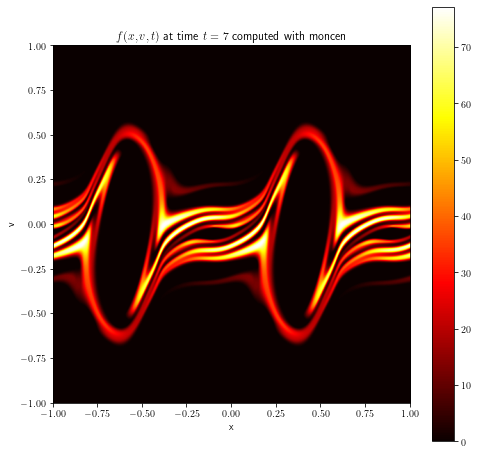

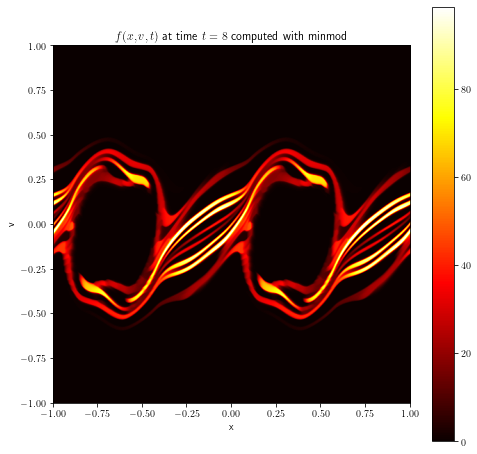

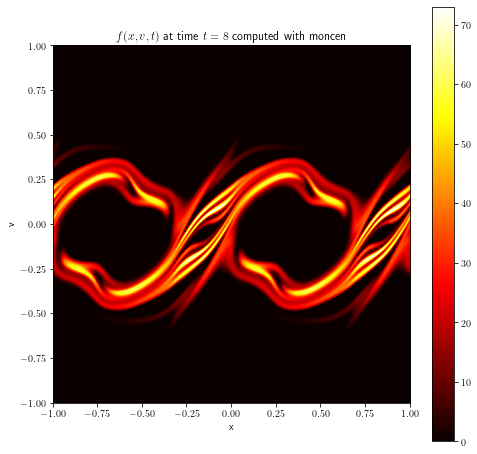

In [26]:
def get_Fo(Nx,Nv):
    """
    initial conditions for f
    """
    dx = 2/Nx
    dv = 2/Nv
    X = np.linspace(-1,1+2*dx, Nx+3) # the points x_{i}, X[0], X[-1] define the same point
    V = np.linspace(-1,1+2*dx,Nv+3) # the points v_{j}, V[0], V[-1] define the same point 
    Xd = X + dx/2 # the points, x_{i+1/2}
    Vd = V + dv/2 # the points, v_{i+1/2}

    Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
    X = Xdgrid.transpose()
    V = Vdgrid.transpose()

    fo = 10*(10+np.sin(2*np.pi*X))*(np.exp(- 1000*(V-.2)**2)+np.exp(- 1000*(V+.3)**2))
    
    # inposes periodicity
    fo[-1,:] = fo[2,:]
    fo[-2,:] = fo[1,:]
    fo[-3,:] = fo[0,:]
    fo[:,-1] = fo[:,2]
    fo[:,-2] = fo[:,1]
    fo[:,-3] = fo[:,0]
    
    return fo

Nx = 512
Ny = 512
Times = [0,1,2,3,4,5,6,7,8]
x = np.linspace(-1,1,Nx+1) + 1/Nx
Fminmod = get_Fo(Nx,Ny)
Fmoncen = get_Fo(Nx,Ny)
plt.imshow(Fminmod.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

for i in range(1,len(Times)):
    Fminmod = vlasov_minmod_integrate(Fminmod,Nx, Ny, Times[i]-Times[i-1])
    Fmoncen = vlasov_moncen_integrate(Fmoncen,Nx, Ny, Times[i]-Times[i-1])
    
    plt.imshow(Fminmod.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {Times[i]}$ computed with minmod")
    plt.show()
    
    plt.imshow(Fmoncen.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {Times[i]}$ computed with moncen")
    plt.show()

We see that both the minmod and moncen limited second-order schemes give a much more resolved picture of the two fluid instability than the first order scheme. We see that minmod very drastically clips the distribution, whereas with moncel, the distribution reamins mostly smooth. This difference in slope limiting causes the distributions to appear very different. 

We finally compare plasma oscilations between minmod and moncen.

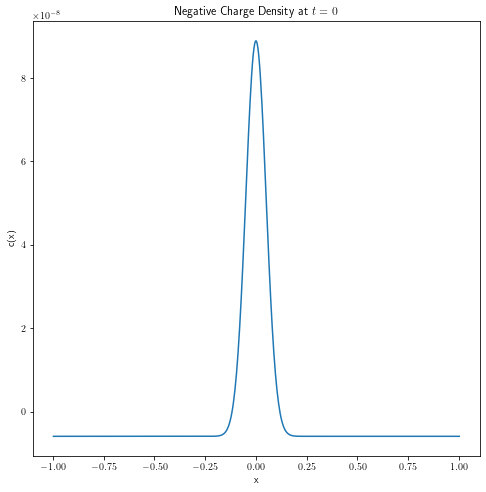

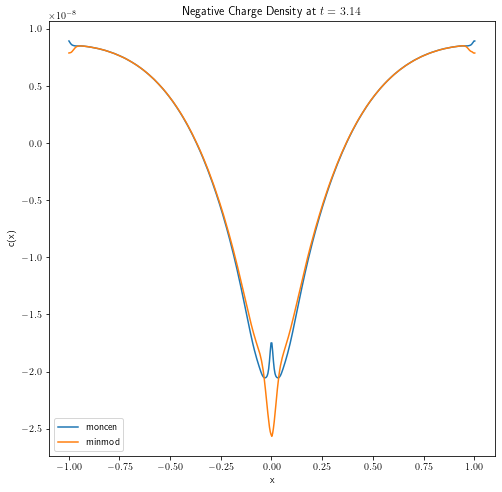

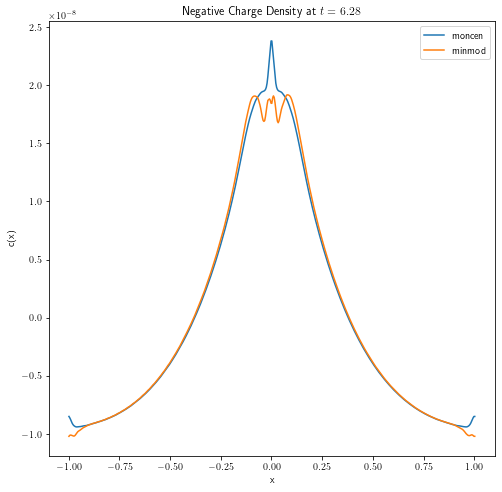

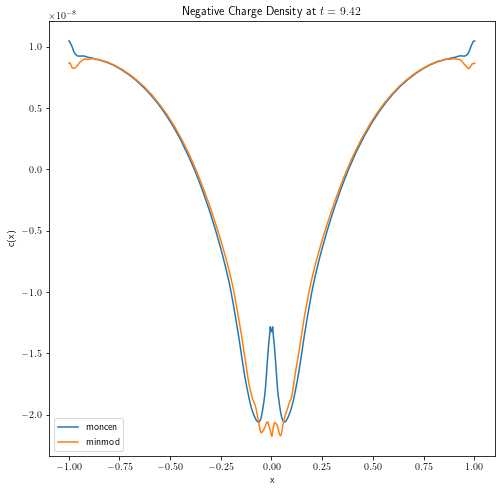

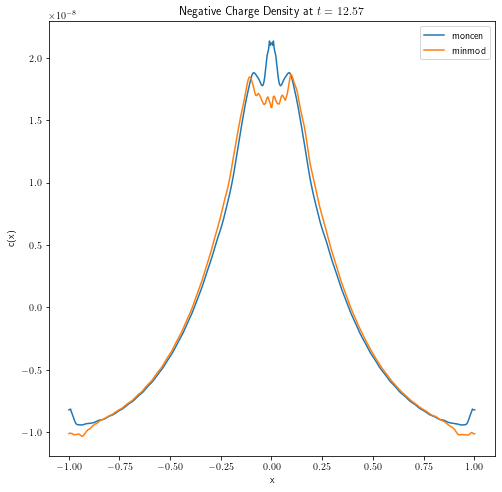

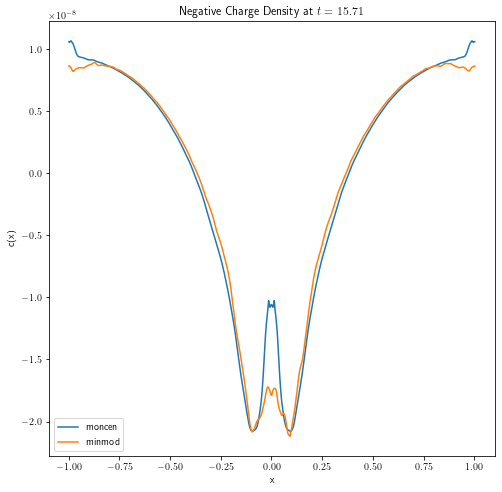

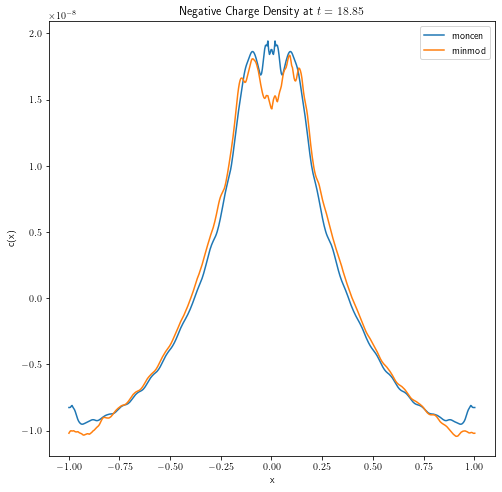

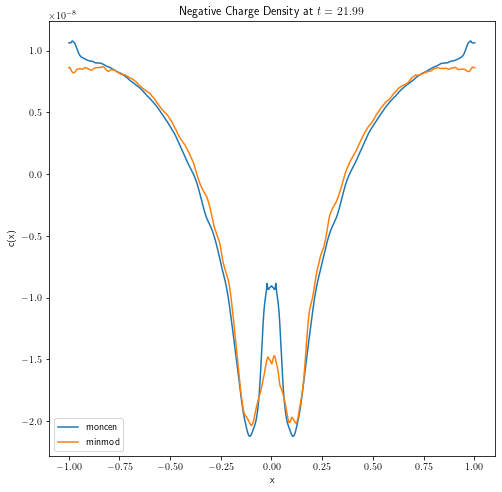

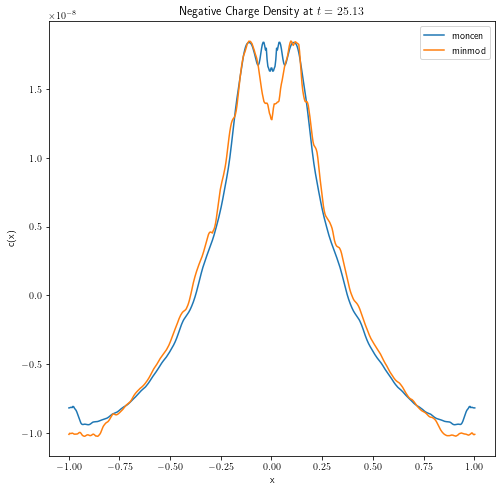

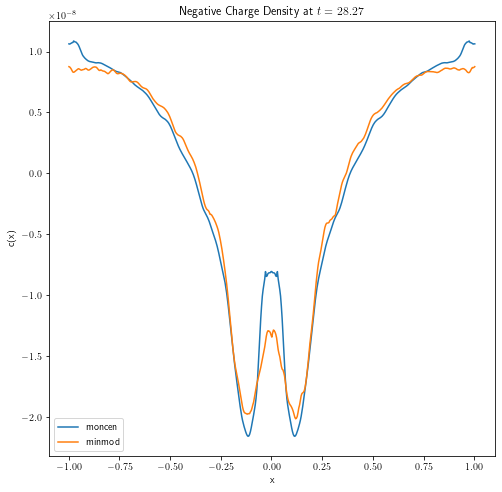

In [27]:
def get_Fo(Nx,Nv):
    """
    initial conditions for f
    """
    dx = 2/Nx
    dv = 2/Nv
    X = np.linspace(-1,1+2*dx, Nx+3) # the points x_{i}, X[0], X[-1] define the same point
    V = np.linspace(-1,1+2*dx,Nv+3) # the points v_{j}, V[0], V[-1] define the same point 
    Xd = X + dx/2 # the points, x_{i+1/2}
    Vd = V + dv/2 # the points, v_{i+1/2}

    Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
    X = Xdgrid.transpose()
    V = Vdgrid.transpose()

    fo = np.exp(- 10000*V**2)/(1/100 * math.sqrt(np.pi)) # f_{0}
    fo = fo + 10**(-8) *.3* np.exp(- 10*V**2)/(1/100 * math.sqrt(np.pi))*\
    (np.exp(-200*X**2))
    
    # inposes periodicity
    fo[-1,:] = fo[2,:]
    fo[-2,:] = fo[1,:]
    fo[-3,:] = fo[0,:]
    fo[:,-1] = fo[:,2]
    fo[:,-2] = fo[:,1]
    fo[:,-3] = fo[:,0]
    
    return fo

Nx = 512
Nv = 512
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1,Nx+1) +1/Nx
Fmoncen = get_Fo(Nx,Nv)
Fminmod = get_Fo(Nx,Nv)
Times = [i*np.pi for i in range(10)]
x = np.linspace(-1,1,Nx+1) + 1/Nx
c = get_charge(Fmoncen, dx,dv)
plt.plot(X,c[0:-2])
plt.title("Negative Charge Density at $t = 0$")
plt.xlabel("x")
plt.ylabel("c(x)")
plt.show()

for i in range(1,len(Times)):
    Fmoncen = vlasov_moncen_integrate(Fmoncen,Nx, Nv, Times[i] - Times[i-1])
    Fminmod = vlasov_minmod_integrate(Fminmod, Nx, Nv, Times[i] - Times[i-1])
    cmoncen = get_charge(Fmoncen, dx, dv)
    cminmod = get_charge(Fminmod, dx, dv)
    
    plt.plot(x,cmoncen[0:-2], label = "moncen")
    plt.plot(x,cminmod[0:-2], label = "minmod")
    plt.title(f"Negative Charge Density at $t = {Times[i]:.2f}$")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("c(x)")
    plt.show()


Unlike with our first order methods, the plasma oscilations are resolved well over long periods. This confirms that our solvers are working correctly. There is very little numerical error. We see that minmod tends to limit the slope of the charge density, whereas moncen is more agressive. 